# 📌 **Pipeline de Modélisation et Optimisation des Modèles**

Ce notebook a pour objectif de :
- Charger et préparer les données pour la modélisation.
- Comparer plusieurs modèles de régression supervisés (Linear Regression, Random Forest, XGBoost, LightGBM).
- Optimiser les modèles sélectionnés avec GridSearchCV.
- Évaluer les performances sur un jeu de test et interpréter les résultats.

In [ ]:
# --- Importation des Bibliothèques ---

# Manipulation des données
import pandas as pd  # Gestion des DataFrames et manipulation de données
import numpy as np  # Calculs numériques avancés
import time  # Mesure du temps d'exécution

# Gestion des fichiers et des répertoires
import os  # Interaction avec le système de fichiers
from pathlib import Path  # Gestion des chemins de fichiers
import sys  # Modification du chemin d'import des modules

# Gestion des logs
from loguru import logger  # Gestion des logs enrichis

# Suppression des avertissements inutiles
import warnings  # Ignorer les warnings pour éviter le bruit dans les sorties
warnings.filterwarnings("ignore")

# Visualisation des données
import matplotlib.pyplot as plt  # Création de graphiques
import seaborn as sns  # Visualisation avancée des données
import plotly.graph_objects as go
import plotly.subplots as sp


# Machine Learning
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV , RandomizedSearchCV, cross_val_score, KFold # Séparation des données et validation croisée
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # Modèles de régression linéaire
from sklearn.ensemble import RandomForestRegressor  # Modèle d'ensemble basé sur les arbres
import xgboost as xgb  # Modèle XGBoost
import lightgbm as lgb  # Modèle LightGBM
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score  # Métriques d'évaluation
from sklearn.utils.validation import check_is_fitted
import shap  # Analyse de l'explicabilité des modèles
from sklearn.preprocessing import StandardScaler
import joblib


import json

# --- Configuration des Affichages Pandas ---
# Permet d'afficher les DataFrames de manière plus lisible
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
pd.set_option('display.max_rows', 150)  # Afficher jusqu'à 150 lignes
pd.set_option('display.width', 300)  # Éviter les retours à la ligne

# --- Configuration des Logs ---
logger.add("../logs/analyse.log", rotation="500 MB")  # Fichier de log avec rotation automatique
logger.info("=" * 60)
logger.info("Démarrage du notebook")
logger.info("=" * 60)

# --- Définition du Répertoire de Travail ---
NOTEBOOK_PATH = Path(os.getcwd())  # Récupération du chemin actuel
BASE_DIR = NOTEBOOK_PATH.parent if NOTEBOOK_PATH.name == "notebooks" else NOTEBOOK_PATH

# Ajout du répertoire 'src' au chemin Python pour les imports de modules personnalisés
sys.path.append(str(BASE_DIR / "src"))

# Définition des répertoires de travail
RAW_DIR = BASE_DIR / "data/raw"  # Données brutes
PROCESSED_DIR = BASE_DIR / "data/processed"  # Données prétraitées
SCRIPTS_DIR = BASE_DIR / "scripts"  # Scripts utiles
OUTPUTS_DIR = BASE_DIR / "outputs"  # Résultats et exports
MODELS_DIR = BASE_DIR / "models"  # Résultats et exports

# --- Fonction pour Configurer et Vérifier les Répertoires ---
def setup_and_log_directories(base_dir, raw_dir, processed_dir, scripts_dir, outputs_dir, models_dir):
    """
    Vérifie et crée les répertoires du projet si nécessaire, puis enregistre les chemins dans les logs.
    
    Args:
        base_dir (Path): Répertoire racine du projet.
        raw_dir (Path): Répertoire des fichiers bruts.
        processed_dir (Path): Répertoire des fichiers nettoyés.
        scripts_dir (Path): Répertoire des scripts.
        outputs_dir (Path): Répertoire des résultats et exports.
        models_dir (Path): Répertoire des modèles créés.

    Returns:
        dict: Dictionnaire contenant les chemins relatifs et absolus.
    """
    try:
        # Définition des chemins relatifs
        raw_dir_relative = raw_dir.relative_to(base_dir)
        processed_dir_relative = processed_dir.relative_to(base_dir)
        scripts_dir_relative = scripts_dir.relative_to(base_dir)
        outputs_dir_relative = outputs_dir.relative_to(base_dir)
        models_dir_relative = models_dir.relative_to(base_dir)

        # Création des répertoires s'ils n'existent pas et journalisation
        for directory, relative_path in zip(
            [raw_dir, processed_dir, scripts_dir, outputs_dir, models_dir],
            [raw_dir_relative, processed_dir_relative, scripts_dir_relative, outputs_dir_relative,models_dir_relative],
        ):
            directory.mkdir(parents=True, exist_ok=True)
            logger.info(f"Répertoire configuré : {base_dir.name}/{relative_path}")
        
        # Retour des chemins absolus et relatifs
        return {
            "base_dir": base_dir,
            "raw_dir": {"absolute": raw_dir, "relative": raw_dir_relative},
            "processed_dir": {"absolute": processed_dir, "relative": processed_dir_relative},
            "scripts_dir": {"absolute": scripts_dir, "relative": scripts_dir_relative},
            "outputs_dir": {"absolute": outputs_dir, "relative": outputs_dir_relative},
            "models_dir": {"absolute": models_dir, "relative": models_dir_relative}
        }
    except Exception as e:
        logger.error(f"Erreur lors de la configuration des répertoires : {e}")
        raise

# Configuration des répertoires et journalisation
directories = setup_and_log_directories(BASE_DIR, RAW_DIR, PROCESSED_DIR, SCRIPTS_DIR, OUTPUTS_DIR, MODELS_DIR)
logger.info("=" * 60)
logger.info("Répertoires vérifiés et configurés avec succès.")
logger.info("=" * 60)

2025-02-24 11:54:33.646 | INFO     | __main__:<module>:51 - ============================================================
2025-02-24 11:54:33.647 | INFO     | __main__:<module>:52 - Démarrage du notebook
2025-02-24 11:54:33.648 | INFO     | __main__:<module>:53 - ============================================================
2025-02-24 11:54:33.650 | INFO     | __main__:setup_and_log_directories:99 - Répertoire configuré : consommation_energie_batiments/data\raw
2025-02-24 11:54:33.651 | INFO     | __main__:setup_and_log_directories:99 - Répertoire configuré : consommation_energie_batiments/data\processed
2025-02-24 11:54:33.652 | INFO     | __main__:setup_and_log_directories:99 - Répertoire configuré : consommation_energie_batiments/scripts
2025-02-24 11:54:33.653 | INFO     | __main__:setup_and_log_directories:99 - Répertoire configuré : consommation_energie_batiments/outputs
2025-02-24 11:54:33.654 | INFO     | __main__:setup_and_log_directories:99 - Répertoire configuré : consommation

In [2]:
# 🚀 Importation des DataFrames en CSV avec encodage UTF-8
logger.info("=" * 60)
logger.info("Début de l'importation du DataFrame en fichier CSV")
logger.info("-" * 10)

# --- Définir le chemin du fichier à charger ---
file_path = directories["processed_dir"]["absolute"]  # Chemin absolu vers le répertoire contenant les données brutes
dataset_file = file_path / "dataset_cleaned.csv"  # Fichier CSV à charger

# --- Vérification de l'existence du fichier ---
if not dataset_file.exists():
    logger.error(f"Le fichier '{dataset_file.name}' est introuvable dans {file_path}.")
    raise FileNotFoundError(f"Fichier non trouvé : {dataset_file}")

try:
    # --- Chargement du fichier CSV ---
    modelisation = pd.read_csv(dataset_file, encoding="utf-8")
    logger.info(f"✅ Fichier '{dataset_file.name}' chargé avec succès.")
    logger.info(f"📊 Nombre de lignes : {modelisation.shape[0]} | Nombre de colonnes : {modelisation.shape[1]}")
except Exception as e:
    logger.error(f"❌ Erreur lors du chargement du fichier : {e}")
    raise
logger.info("-" * 10)
logger.info("Fin de l'importation du DataFrame en fichier CSV")
logger.info("=" * 60)

2025-02-24 11:54:33.665 | INFO     | __main__:<module>:2 - ============================================================
2025-02-24 11:54:33.666 | INFO     | __main__:<module>:3 - Début de l'importation du DataFrame en fichier CSV
2025-02-24 11:54:33.667 | INFO     | __main__:<module>:4 - ----------
2025-02-24 11:54:33.676 | INFO     | __main__:<module>:18 - ✅ Fichier 'dataset_cleaned.csv' chargé avec succès.
2025-02-24 11:54:33.678 | INFO     | __main__:<module>:19 - 📊 Nombre de lignes : 1668 | Nombre de colonnes : 31
2025-02-24 11:54:33.681 | INFO     | __main__:<module>:23 - ----------
2025-02-24 11:54:33.683 | INFO     | __main__:<module>:24 - Fin de l'importation du DataFrame en fichier CSV
2025-02-24 11:54:33.684 | INFO     | __main__:<module>:25 - ============================================================


In [3]:
# Afficher les dimensions du dataset après filtrage
logger.info("=" * 60)
logger.info(f"Nombre de lignes : {modelisation.shape[0]}")
logger.info(f"Nombre de colonnes : {modelisation.shape[1]}")

# 🔹 Affichage d’un aperçu des données
logger.info("=" * 60)
logger.info("📌 Aperçu des données (échantillon aléatoire) :")
logger.info(f"\n {modelisation.sample(5)}")
logger.info("=" * 60)

2025-02-24 11:54:33.695 | INFO     | __main__:<module>:2 - ============================================================
2025-02-24 11:54:33.696 | INFO     | __main__:<module>:3 - Nombre de lignes : 1668
2025-02-24 11:54:33.697 | INFO     | __main__:<module>:4 - Nombre de colonnes : 31
2025-02-24 11:54:33.698 | INFO     | __main__:<module>:7 - ============================================================
2025-02-24 11:54:33.699 | INFO     | __main__:<module>:8 - 📌 Aperçu des données (échantillon aléatoire) :
2025-02-24 11:54:33.706 | INFO     | __main__:<module>:9 - 
       building_type  site_eui  site_energy_use  compliance_status  ghg_emissions_total  property_type_education  property_type_office  property_type_other  property_type_storage  neighborhood_east  neighborhood_north  neighborhood_south  neighborhood_west  property_use_list_office  \
373               0  1.637224         2.126924                  0             2.163166                        0                     0         

Comme nous avons **deux modèles à entraîner**, cela signifie que nous allons créer **deux DataFrames distincts** :

1. **Modèle 1 : Prédiction de la consommation d’énergie (`site_energy_use`)**  
   - Features (`X1`): Toutes les variables explicatives sauf `site_energy_use`
   - Cible (`y1`): `site_energy_use`

2. **Modèle 2 : Prédiction des émissions de CO2 (`ghg_emissions_total`)**  
   - Features (`X2`): Toutes les variables explicatives sauf `ghg_emissions_total`
   - Cible (`y2`): `ghg_emissions_total`

 

 ✅ **Doit-on garder la variable cible d'un modèle dans l'autre DataFrame (celui des features) ?**  
 

**1️⃣ Garder la variable cible du modèle 1 (`site_energy_use`) dans les features du modèle 2 ?**
- Si l'objectif est de **prédire `ghg_emissions_total`** et que **`site_energy_use` est un bon prédicteur** des émissions de CO2 (ce qui est probable), alors **oui, on peut la garder**.
- En effet, la consommation énergétique influence fortement les émissions de CO2. Ce serait donc une **feature utile**.

✅ **Conclusion : `site_energy_use` peut rester dans `X_train_co2`**  
 
 

**2️⃣ Garder la variable cible du modèle 2 (`ghg_emissions_total`) dans les features du modèle 1 ?**
- Si l'objectif est de **prédire `site_energy_use`**, alors garder **`ghg_emissions_total` dans les features** peut poser un **problème de fuite de données**.
- En pratique, les émissions de CO2 sont souvent **calculées à partir de la consommation d’énergie**. Cela signifie qu'utiliser `ghg_emissions_total` pour prédire `site_energy_use` pourrait biaiser le modèle, car c'est **une conséquence directe de la cible**.

❌ **Conclusion : `ghg_emissions_total` ne doit PAS être une feature dans `X_train_energy`**  

In [4]:
def prepare_data(df, target_var, exclude_vars=None, test_size=0.2, random_state=42, scale_numeric=False):
    """
    Prépare les données pour la modélisation :
    - Sépare les features (X) et la cible (y)
    - Vérifie que les features de X_train et X_test sont alignées
    - Gère les valeurs manquantes et les doublons
    - Sépare en train/test
    - (Optionnel) Standardise les variables numériques

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données.
        target_var (str): La colonne cible à prédire.
        exclude_vars (list, optional): Liste des variables à exclure de X. Par défaut, aucune.
        test_size (float): Proportion des données utilisées pour le test.
        random_state (int): Graine pour la reproductibilité.
        scale_numeric (bool): Applique une standardisation des variables numériques.

    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """
    try:
        # Initialisation de exclude_vars si None
        exclude_vars = exclude_vars or []

        # Vérification que la cible existe
        if target_var not in df.columns:
            raise ValueError(f"❌ La colonne cible '{target_var}' n'existe pas dans le DataFrame.")

        # Gestion des valeurs manquantes
        missing_values = df.isnull().sum().sum()
        if missing_values > 0:
            logger.warning(f"⚠️ {missing_values} valeurs manquantes détectées dans le dataset.")

        # Exclusion des variables non pertinentes
        exclude_vars = list(set(exclude_vars + [target_var]))  # Assurer l'unicité des exclusions
        
        if target_var == "site_energy_use":
            exclude_vars.append("ghg_emissions_total")  # Exclusion stricte pour éviter la fuite de données

        # Séparation des features et de la cible
        X = df.drop(columns=exclude_vars, errors='ignore')
        y = df[target_var]

        # Ajout de `site_energy_use` dans `X_train_co2` si on prédit `ghg_emissions_total`
        if target_var == "ghg_emissions_total" and "site_energy_use" not in X.columns:
            logger.info("🔹 Ajout de `site_energy_use` comme feature pour prédire `ghg_emissions_total`.")
            X["site_energy_use"] = df["site_energy_use"]

        # Vérification et suppression des doublons
        duplicate_count = df.duplicated().sum()
        if duplicate_count > 0:
            logger.warning(f"⚠️ {duplicate_count} doublons détectés dans les données.")

        # Séparation Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Alignement des features entre X_train et X_test
        X_test = X_test[X_train.columns]

        # Standardisation des variables numériques si demandé
        if scale_numeric:
            numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
            scaler = StandardScaler()
            X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
            X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
            logger.info("📏 Standardisation des variables numériques appliquée.")

        # Logs des dimensions des jeux de données
        logger.info(f"✅ Données préparées pour {target_var}")
        logger.info(f"📊 X_train: {X_train.shape}, X_test: {X_test.shape}")
        logger.info(f"🎯 y_train: {y_train.shape}, y_test: {y_test.shape}")
        logger.info(f"📋 Premières features utilisées : {', '.join(X_train.columns[:10])}...")

        return X_train, X_test, y_train, y_test

    except Exception as e:
        logger.error(f"❌ Erreur dans prepare_data() : {e}")
        raise

In [5]:
# 🔹 Création des jeux de données
logger.info("=" * 60)

# 🔹 Modèle 1 : Prédiction de la consommation d’énergie (sans `ghg_emissions_total`)
X_train_energy, X_test_energy, y_train_energy, y_test_energy = prepare_data(
    modelisation, "site_energy_use", exclude_vars=["ghg_emissions_total"], scale_numeric=True
)

logger.info("-" * 60)
 
logger.info(f"📌 Présence de `site_energy_use` dans X_train_energy après préparation : {'site_energy_use' in X_train_energy.columns}")
logger.info(f"📌 Présence de `site_energy_use` dans X_test_energy après préparation : {'site_energy_use' in X_test_energy.columns}")
logger.info("=" * 60)

2025-02-24 11:54:33.728 | INFO     | __main__:<module>:2 - ============================================================
2025-02-24 11:54:33.739 | INFO     | __main__:prepare_data:66 - 📏 Standardisation des variables numériques appliquée.
2025-02-24 11:54:33.741 | INFO     | __main__:prepare_data:69 - ✅ Données préparées pour site_energy_use
2025-02-24 11:54:33.743 | INFO     | __main__:prepare_data:70 - 📊 X_train: (1334, 29), X_test: (334, 29)
2025-02-24 11:54:33.744 | INFO     | __main__:prepare_data:71 - 🎯 y_train: (1334,), y_test: (334,)
2025-02-24 11:54:33.745 | INFO     | __main__:prepare_data:72 - 📋 Premières features utilisées : building_type, site_eui, compliance_status, property_type_education, property_type_office, property_type_other, property_type_storage, neighborhood_east, neighborhood_north, neighborhood_south...
2025-02-24 11:54:33.747 | INFO     | __main__:<module>:9 - ------------------------------------------------------------
2025-02-24 11:54:33.748 | INFO     | __m

In [6]:
logger.info("=" * 60)

# 🔹 Modèle 2 : Prédiction des émissions de CO2 (avec `site_energy_use` comme feature)
X_train_co2, X_test_co2, y_train_co2, y_test_co2 = prepare_data(
    modelisation, "ghg_emissions_total", scale_numeric=True
)

logger.info("-" * 60)
 
logger.info(f"📌 Présence de `site_energy_use` dans X_train_co2 après préparation : {'site_energy_use' in X_train_co2.columns}")
logger.info(f"📌 Présence de `site_energy_use` dans X_test_co2 après préparation : {'site_energy_use' in X_test_co2.columns}")
logger.info("=" * 60)

2025-02-24 11:54:33.759 | INFO     | __main__:<module>:1 - ============================================================
2025-02-24 11:54:33.771 | INFO     | __main__:prepare_data:66 - 📏 Standardisation des variables numériques appliquée.
2025-02-24 11:54:33.772 | INFO     | __main__:prepare_data:69 - ✅ Données préparées pour ghg_emissions_total
2025-02-24 11:54:33.773 | INFO     | __main__:prepare_data:70 - 📊 X_train: (1334, 30), X_test: (334, 30)
2025-02-24 11:54:33.774 | INFO     | __main__:prepare_data:71 - 🎯 y_train: (1334,), y_test: (334,)
2025-02-24 11:54:33.775 | INFO     | __main__:prepare_data:72 - 📋 Premières features utilisées : building_type, site_eui, site_energy_use, compliance_status, property_type_education, property_type_office, property_type_other, property_type_storage, neighborhood_east, neighborhood_north...
2025-02-24 11:54:33.776 | INFO     | __main__:<module>:8 - ------------------------------------------------------------
2025-02-24 11:54:33.777 | INFO     | __

In [7]:
# --- Fonction pour entraîner et évaluer un modèle
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Entraîne un modèle de régression et évalue ses performances sur les données de test.

    Args:
        model (object): Modèle de régression (ex: LinearRegression, RandomForestRegressor, etc.).
        X_train (pd.DataFrame): Variables explicatives pour l'entraînement.
        X_test (pd.DataFrame): Variables explicatives pour le test.
        y_train (pd.Series): Cible pour l'entraînement.
        y_test (pd.Series): Cible pour le test.

    Returns:
        dict: Contient les métriques de performance du modèle (R², RMSE, MAE, Temps d'exécution).
    """
    try:
        start_time = time.time()  # ⏳ Démarrer le chronomètre pour mesurer le temps d'entraînement
        
        # 🚀 Entraînement du modèle
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)  # 📊 Prédictions sur le jeu de test
        
        execution_time = time.time() - start_time  # ⏱️ Calcul du temps d'exécution

        # 📊 Calcul des métriques d'évaluation
        metrics = {
            "R²": r2_score(y_test, y_pred),  # Performance globale du modèle (1 = parfait)
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # Erreur quadratique moyenne
            "MAE": mean_absolute_error(y_test, y_pred),  # Erreur absolue moyenne
            "Execution Time (s)": execution_time  # Temps total d'entraînement et de prédiction
        }

        return metrics  # 🔙 Retourne les métriques du modèle
    except Exception as e:
        # 🚨 Capture des erreurs pour éviter un crash du programme
        logger.error(f"❌ Erreur lors de l'évaluation du modèle {model.__class__.__name__} : {e}")
        return {"R²": None, "RMSE": None, "MAE": None, "Execution Time (s)": None}  # 🔄 Retourne des valeurs vides

# --- Fonction pour comparer plusieurs modèles
def compare_models(X_train, X_test, y_train, y_test):
    """
    Entraîne et compare plusieurs modèles de régression.

    Args:
        X_train (pd.DataFrame): Variables explicatives pour l'entraînement.
        X_test (pd.DataFrame): Variables explicatives pour le test.
        y_train (pd.Series): Cible pour l'entraînement.
        y_test (pd.Series): Cible pour le test.

    Returns:
        pd.DataFrame: Tableau comparatif des performances des modèles.
    """
    # 📌 Définition des modèles à tester
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "Random Forest": RandomForestRegressor(),
        "XGBoost": xgb.XGBRegressor(),
        "LightGBM": lgb.LGBMRegressor(verbosity=-1)  # Désactivation des logs LightGBM pour éviter du bruit inutile
    }

    results = {}  # 📊 Stockage des performances des modèles
    for name, model in models.items():
        logger.info(f"🔍 Entraînement et évaluation du modèle : {name}")
        model_results = evaluate_model(model, X_train, X_test, y_train, y_test)

        # ✅ Ajouter le modèle dans les résultats seulement s'il a bien fonctionné
        if model_results["R²"] is not None:
            results[name] = model_results
            logger.info(f"✅ {name} → R²: {model_results['R²']:.4f} | RMSE: {model_results['RMSE']:.4f} | MAE: {model_results['MAE']:.4f}")
        else:
            logger.warning(f"⚠️ {name} exclu des résultats (échec de l'entraînement).")

    # 📊 Transformation des résultats en DataFrame, trié par R² (le meilleur en premier)
    results_df = pd.DataFrame(results).T.sort_values(by="R²", ascending=False)

    # 📊 Génération des graphiques pour visualiser les résultats
    plot_model_comparison(results_df)

    return results_df  # 🔙 Retourne le tableau des performances

# --- Fonction pour visualiser les performances des modèles
def plot_model_comparison(results_df):
    """
    Génère des graphiques pour comparer les performances des modèles.

    Args:
        results_df (pd.DataFrame): Tableau des résultats des modèles.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 🎨 Création de 3 sous-graphiques

    # 🔹 Définition des couleurs par métrique
    palettes = {"R²": "Blues_r", "MAE": "Reds_r", "RMSE": "Greens_r"}

    for i, metric in enumerate(["R²", "MAE", "RMSE"]):  
        sns.barplot(ax=axes[i], x=results_df.index, y=results_df[metric], palette=palettes[metric])  # 📊 Création du barplot
        axes[i].set_title(f"Comparaison des {metric}", fontsize=10, fontweight="bold")  # 🏷️ Titre légèrement réduit
        axes[i].set_ylabel(metric, fontsize=9)  # 🎯 Légende de l'axe Y réduite
        axes[i].set_xticklabels(results_df.index, rotation=90, fontsize=8)  # 🔄 Rotation des labels avec texte plus petit

        # 🔹 Fixer une échelle uniforme entre 0 et 1.2 pour toutes les métriques
        axes[i].set_ylim(0, 1.2)

        # 📊 Ajout des valeurs sur les barres avec une taille de texte réduite
        for index, value in enumerate(results_df[metric]):
            axes[i].text(index, value + 0.02, f"{value:.2f}", ha="center", fontsize=8)

    # 📊 Titre global avec une taille de texte légèrement réduite
    fig.suptitle("📊 Comparaison des performances des modèles", fontsize=11, fontweight="bold")

    plt.tight_layout()  # Ajustement automatique pour éviter le chevauchement
    plt.show()  # 🔍 Affichage du graphique


2025-02-24 11:54:33.798 | INFO     | __main__:<module>:2 - ============================================================
2025-02-24 11:54:33.799 | INFO     | __main__:<module>:3 - 🚀 Test des modèles pour la consommation d'énergie
2025-02-24 11:54:33.800 | INFO     | __main__:compare_models:65 - 🔍 Entraînement et évaluation du modèle : Linear Regression
2025-02-24 11:54:33.815 | INFO     | __main__:compare_models:71 - ✅ Linear Regression → R²: 0.7629 | RMSE: 0.4821 | MAE: 0.3419
2025-02-24 11:54:33.816 | INFO     | __main__:compare_models:65 - 🔍 Entraînement et évaluation du modèle : Ridge
2025-02-24 11:54:33.827 | INFO     | __main__:compare_models:71 - ✅ Ridge → R²: 0.7630 | RMSE: 0.4821 | MAE: 0.3417
2025-02-24 11:54:33.828 | INFO     | __main__:compare_models:65 - 🔍 Entraînement et évaluation du modèle : Lasso
2025-02-24 11:54:33.833 | INFO     | __main__:compare_models:71 - ✅ Lasso → R²: -0.0002 | RMSE: 0.9902 | MAE: 0.8011
2025-02-24 11:54:33.834 | INFO     | __main__:compare_model

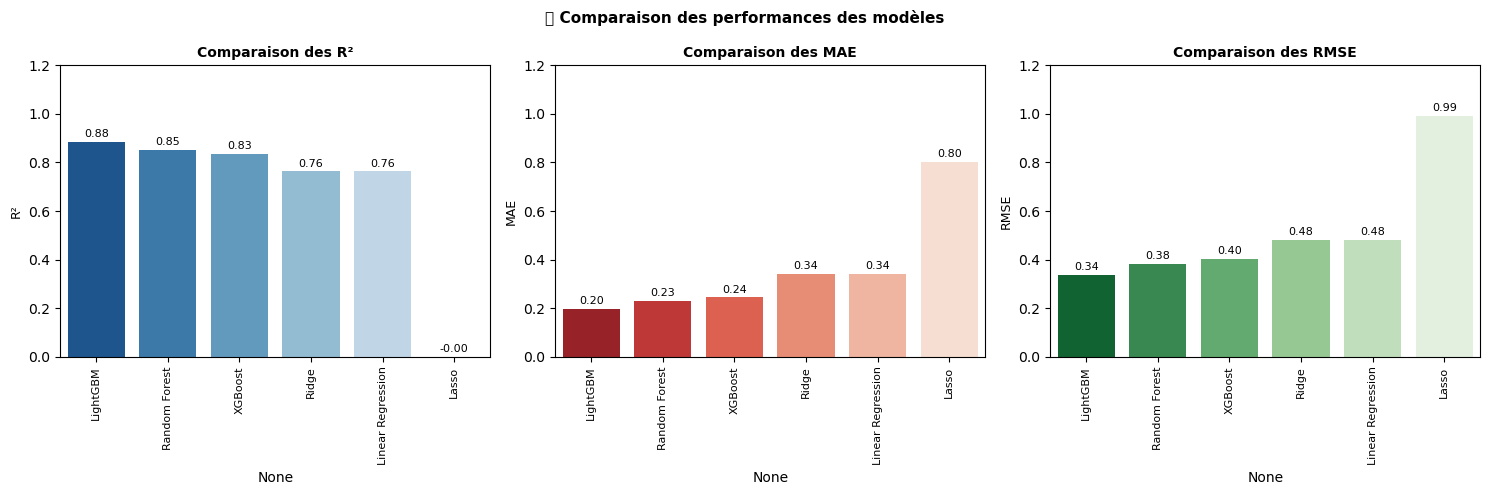

2025-02-24 11:54:34.932 | INFO     | __main__:<module>:5 - ============================================================


In [8]:
# 🔹 Tester les modèles pour la consommation d'énergie
logger.info("=" * 60)
logger.info("🚀 Test des modèles pour la consommation d'énergie")
results_energy = compare_models(X_train_energy, X_test_energy, y_train_energy, y_test_energy)
logger.info("=" * 60)

2025-02-24 11:54:34.939 | INFO     | __main__:<module>:2 - ============================================================
2025-02-24 11:54:34.940 | INFO     | __main__:<module>:3 - 🚀 Test des modèles pour les émissions de CO2
2025-02-24 11:54:34.942 | INFO     | __main__:compare_models:65 - 🔍 Entraînement et évaluation du modèle : Linear Regression
2025-02-24 11:54:34.953 | INFO     | __main__:compare_models:71 - ✅ Linear Regression → R²: 0.8274 | RMSE: 0.4010 | MAE: 0.2857
2025-02-24 11:54:34.954 | INFO     | __main__:compare_models:65 - 🔍 Entraînement et évaluation du modèle : Ridge
2025-02-24 11:54:34.960 | INFO     | __main__:compare_models:71 - ✅ Ridge → R²: 0.8274 | RMSE: 0.4010 | MAE: 0.2857
2025-02-24 11:54:34.961 | INFO     | __main__:compare_models:65 - 🔍 Entraînement et évaluation du modèle : Lasso
2025-02-24 11:54:34.966 | INFO     | __main__:compare_models:71 - ✅ Lasso → R²: -0.0000 | RMSE: 0.9652 | MAE: 0.7870
2025-02-24 11:54:34.967 | INFO     | __main__:compare_models:65 

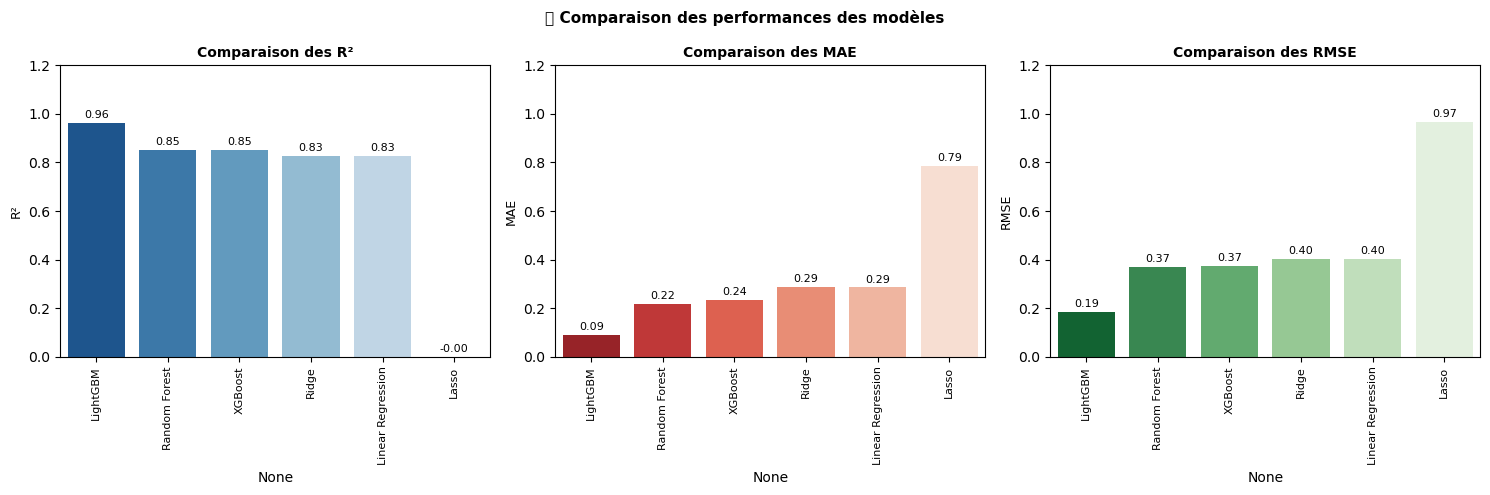

2025-02-24 11:54:35.942 | INFO     | __main__:<module>:5 - ============================================================


In [9]:
# 🔹 Tester les modèles pour les émissions de CO2
logger.info("=" * 60)
logger.info("🚀 Test des modèles pour les émissions de CO2")
results_co2 = compare_models(X_train_co2, X_test_co2, y_train_co2, y_test_co2)
logger.info("=" * 60)

### **🔹 Consommation d'Énergie**
- **🏆 Meilleur modèle : LightGBM**
  - **R² = 0.88** → **Très bonne précision.**
  - **MAE = 0.20** → **Bonne précision absolue.**
  - **RMSE = 0.34** → **Bonne stabilité.**
  - **Rapidité : très rapide.**

- **🥈 Random Forest**
  - **R² = 0.84** → Très bon.
  - **MAE = 0.24** → Un peu moins bon que LightGBM.
  - **RMSE = 0.39** → Erreur plus élevée que LightGBM.
  - **Temps d'exécution plus long.**

- **🥉 XGBoost**
  - **R² = 0.83**, proche de Random Forest.
  - **MAE = 0.24**, similaire à Random Forest.
  - **RMSE = 0.40**, légèrement moins bon.
  - **Un peu plus rapide que Random Forest.**

- **❌ Modèles Linéaires (Ridge, Lasso, Régression Linéaire)**
  - **R² entre 0.76 et 0.00** → Performances inférieures aux modèles d'arbres.
  - **Lasso est inutilisable (R² ≈ 0).**
  - **À exclure des prochaines étapes.**

---

### **🔹 Émissions de CO₂**
- **🏆 Meilleur modèle : LightGBM**
  - **R² = 0.96** → **Meilleure précision.**
  - **MAE = 0.09**, plus faible erreur absolue.
  - **RMSE = 0.19**, bonne stabilité.

- **🥈 XGBoost**
  - **R² = 0.85**, très proche de Random Forest.
  - **MAE = 0.24**, légèrement plus élevé.
  - **RMSE = 0.38**, légèrement plus d'erreur que LightGBM.

- **🥉 Random Forest**
  - **R² = 0.85**, similaire à XGBoost.
  - **MAE = 0.22**, légèrement meilleur que XGBoost.
  - **RMSE = 0.37**, performances proches.

- **❌ Lasso, Régression Linéaire et Ridge**
  - **R² ≈ 0** pour Lasso → **Modèle inutilisable.**
  - **Linear Regression et Ridge sont bien en dessous des modèles d’ensemble.**

---

### **🎯 Conclusion**
1. **LightGBM est le meilleur modèle** en termes de **précision et rapidité**.
2. **XGBoost et Random Forest sont compétitifs**, mais avec une légère baisse de performance.
3. **Les modèles linéaires sont globalement inefficaces**, surtout Lasso.

1. **R² (Coefficient de Détermination)**  
   - Indique **la proportion de variance expliquée** par le modèle.  
   - Un **R² proche de 1** signifie que le modèle explique bien les variations des données.  
   - Un **R² proche de 0** signifie que le modèle ne capture pas bien la tendance des données.  
   - Si **R² est négatif**, le modèle est pire qu’une prédiction moyenne constante.

2. **RMSE (Root Mean Squared Error - Erreur Quadratique Moyenne)**  
   - Mesure **l'écart moyen** entre les valeurs réelles et les prédictions, en **donnant plus de poids aux grandes erreurs** (car il élève les écarts au carré).  
   - Plus le **RMSE est faible**, plus le modèle est précis.  
   - Exprimé **dans les mêmes unités** que la variable cible.

3. **MAE (Mean Absolute Error - Erreur Absolue Moyenne)**  
   - Indique **l'erreur moyenne absolue** entre les prédictions et les vraies valeurs.  
   - Contrairement au **RMSE**, il **ne pénalise pas autant** les grandes erreurs.  
   - Exprimé **dans les mêmes unités** que la variable cible.  

👉 **En résumé** :  
- **R²** → Capacité explicative du modèle (**plus c'est proche de 1, mieux c'est**).  
- **RMSE** → Erreur moyenne **avec pénalité sur les grosses erreurs** (**plus c'est bas, mieux c'est**).  
- **MAE** → Erreur moyenne simple, **moins sensible aux grosses erreurs**.  

💡 **Astuce** : RMSE est souvent préféré à MAE lorsqu'on veut éviter les grosses erreurs, mais MAE est plus facile à interpréter ! 🔍

Les paramètres dans `param_grids` ont été choisis selon **les meilleures pratiques et l'efficacité computationnelle** :

- **Random Forest** :  
  - `n_estimators` (100, 200, 300) : Plus d’arbres augmentent la stabilité.
  - `max_depth` (5, 10, None) : 5 et 10 pour limiter le sur-apprentissage, `None` pour laisser croître librement.
  - `min_samples_split` (2, 5, 10) : Contrôle la taille minimale d’un split pour éviter des arbres trop complexes.

- **XGBoost & LightGBM** :  
  - `n_estimators` (100, 200) : Limité pour éviter un coût de calcul trop élevé.
  - `max_depth` (3, 5, 7) : Petites profondeurs favorisent la généralisation.
  - `learning_rate` (0.01, 0.1, 0.2) : 0.01 pour une convergence lente mais précise, 0.1-0.2 pour un compromis rapidité/précision.

Ces valeurs offrent un **bon équilibre** entre performance et temps d'entraînement. On peut les affiner avec des tests supplémentaires 🚀.

In [10]:
def optimize_model(X_train, y_train, model_name, target_var):
    """
    Optimise un modèle donné avec GridSearchCV et retourne le meilleur modèle entraîné.

    Cette fonction sélectionne les hyperparamètres optimaux pour un modèle donné
    en utilisant la validation croisée GridSearchCV. Le modèle optimisé est ensuite 
    sauvegardé avec un nom unique pour éviter d’écraser d'autres modèles.

    Args:
        X_train (pd.DataFrame): Données d'entraînement des variables explicatives.
        y_train (pd.Series): Données d'entraînement de la variable cible.
        model_name (str): Nom du modèle à optimiser ('Random Forest', 'XGBoost', 'LightGBM').
        target_var (str): Nom de la variable cible ('site_energy_use' ou 'ghg_emissions_total').

    Returns:
        model: Le meilleur modèle entraîné avec les hyperparamètres optimaux.
    """
    try:
        # 📌 Définition des grilles d'hyperparamètres pour chaque modèle
        param_grids = {
            "Random Forest": {
                "n_estimators": [100, 200, 300],  # Nombre d'arbres dans la forêt
                "max_depth": [5, 10, None],  # Profondeur maximale des arbres
                "min_samples_split": [2, 5, 10]  # Nombre min d'échantillons pour diviser un nœud
            },
            "XGBoost": {
                "n_estimators": [100, 200],  # Nombre d'arbres
                "max_depth": [3, 5, 7],  # Profondeur maximale des arbres
                "learning_rate": [0.01, 0.1, 0.2]  # Taux d'apprentissage
            },
            "LightGBM": {
                "n_estimators": [100, 200],  # Nombre d'arbres
                "max_depth": [-1, 5, 10],  # Profondeur maximale (-1 signifie aucune limite)
                "learning_rate": [0.01, 0.1, 0.2]  # Taux d'apprentissage
            }
        }

        # 📌 Dictionnaire associant le nom du modèle avec sa classe
        model_classes = {
            "Random Forest": RandomForestRegressor(),
            "XGBoost": xgb.XGBRegressor(),
            "LightGBM": lgb.LGBMRegressor()
        }

        # 🚨 Vérification que le modèle est bien supporté
        if model_name not in param_grids:
            raise ValueError(f"❌ Modèle '{model_name}' non supporté.")

        logger.info(f"🚀 Début de l'optimisation pour {model_name} ({target_var})")

        # 🔍 Création de l'objet GridSearchCV pour rechercher les meilleurs hyperparamètres
        grid_search = GridSearchCV(
            estimator=model_classes[model_name],  # Modèle à optimiser
            param_grid=param_grids[model_name],  # Grille des hyperparamètres à tester
            cv=5,  # Validation croisée avec 5 folds
            scoring="r2",  # Score utilisé pour la sélection du meilleur modèle
            n_jobs=-1  # Utilisation de tous les cœurs disponibles pour accélérer le calcul
        )

        # 🏋️ Entraînement du modèle avec GridSearchCV
        grid_search.fit(X_train, y_train)

        # 💾 Génération d'un nom unique pour sauvegarder le modèle optimisé
        model_filename = f"best_model_{model_name}_{target_var}.pkl"
        joblib.dump(grid_search.best_estimator_, model_filename)
        logger.info(f"✅ Modèle sauvegardé sous : {model_filename}")

        return grid_search.best_estimator_

    except Exception as e:
        logger.error(f"❌ Erreur dans optimize_model() : {e}")
        raise


- **Le rôle de GridSearchCV** : recherche exhaustive des meilleures combinaisons d'hyperparamètres avec validation croisée.
- **Chaque étape du processus** : définition des grilles d'hyperparamètres, association des modèles, création et exécution de GridSearchCV.
- **Les paramètres utilisés** : validation croisée `cv=5`, critère d’évaluation `scoring="r2"`, et utilisation des cœurs `n_jobs=-1` pour optimiser la vitesse.

In [11]:
def test_best_models(X_train, X_test, y_train, y_test, top_models, target_var):
    """
    Teste et compare les 3 meilleurs modèles après optimisation.

    Cette fonction :
    - Charge les modèles s'ils existent déjà, sinon les entraîne.
    - Effectue des prédictions sur les données de test.
    - Calcule et stocke les métriques de performance pour chaque modèle.
    - Retourne un tableau récapitulatif des performances.

    Args:
        X_train (pd.DataFrame): Données d'entraînement des variables explicatives.
        X_test (pd.DataFrame): Données de test des variables explicatives.
        y_train (pd.Series): Données d'entraînement de la variable cible.
        y_test (pd.Series): Données de test de la variable cible.
        top_models (list): Liste des modèles à tester et comparer.
        target_var (str): Variable cible ('site_energy_use' ou 'ghg_emissions_total').

    Returns:
        pd.DataFrame: Tableau récapitulatif des performances des modèles trié par R².
    """
    results = {}  # 📊 Stockage des performances des modèles

    for model_name in top_models:
        # 📌 Génération du chemin du modèle sauvegardé dans le répertoire MODELS_DIR
        model_path = MODELS_DIR / f"best_model_{model_name}_{target_var}.pkl"

        try:
            # 📌 Tenter de charger le modèle sauvegardé
            best_model = joblib.load(model_path)
        except FileNotFoundError:
            # 🏋️ Si le modèle n'existe pas, l'entraîner
            print(f"🔍 Modèle {model_name} non trouvé, optimisation en cours...")
            best_model = optimize_model(X_train, y_train, model_name, target_var)
            joblib.dump(best_model, model_path)  # 💾 Sauvegarde du modèle entraîné

        # 📌 Récupération des features utilisées à l'entraînement
        trained_features = getattr(best_model, "feature_names_in_", None)
        if trained_features is not None:
            trained_features = list(trained_features)  # Liste des features utilisées
        else:
            trained_features = X_train.columns.tolist()  # Utilisation de X_train.columns si indisponible

        # 🚨 Vérification et alignement des colonnes entre X_train et X_test
        if set(trained_features) != set(X_test.columns):
            print(f"⚠️ Correction des features pour {model_name} ({target_var})")
            X_test = X_test[trained_features]  # Supprimer les colonnes en trop si nécessaire

        try:
            # 🔮 Prédictions du modèle sur X_test
            y_pred = best_model.predict(X_test)

            # 📊 Calcul des métriques de performance
            metrics = {
                "R²": r2_score(y_test, y_pred),  # Score de détermination
                "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # Erreur quadratique moyenne
                "MAE": mean_absolute_error(y_test, y_pred),  # Erreur absolue moyenne
            }

            # 🔄 Stocker les résultats pour comparaison future
            results[model_name] = metrics

        except Exception as e:
            print(f"❌ Erreur lors de la prédiction avec {model_name} ({target_var}) : {e}")
            results[model_name] = {"R²": None, "RMSE": None, "MAE": None}

    # 📊 Création du tableau récapitulatif
    results_df = pd.DataFrame(results).T.sort_values(by="R²", ascending=False)

    # 📌 Affichage du tableau des résultats
    print("\n📊 Tableau récapitulatif des modèles :\n", results_df)

    return results_df


In [12]:
# 🔹 Sélectionner les 3 meilleurs modèles identifiés
best_models_energy = ["Random Forest", "LightGBM", "XGBoost"]
 
# 🔹 Tester et comparer pour la consommation d'énergie
logger.info("🚀 Comparaison des modèles pour la consommation d'énergie")
results_energy_bm = test_best_models(X_train_energy, X_test_energy, y_train_energy, y_test_energy, best_models_energy, "site_energy_use")


2025-02-24 11:54:35.977 | INFO     | __main__:<module>:5 - 🚀 Comparaison des modèles pour la consommation d'énergie



📊 Tableau récapitulatif des modèles :
                      R²      RMSE       MAE
LightGBM       0.872970  0.352887  0.215200
Random Forest  0.847131  0.387117  0.235560
XGBoost        0.836820  0.399958  0.240895


In [13]:
# 🔹 Sélectionner les 3 meilleurs modèles identifiés 
best_models_co2 = ["Random Forest", "LightGBM", "XGBoost"]
 
# 🔹 Tester et comparer pour les émissions de CO₂
logger.info("🚀 Comparaison des modèles pour les émissions de CO₂")
results_co2_bm = test_best_models(X_train_co2, X_test_co2, y_train_co2, y_test_co2, best_models_co2, "ghg_emissions_total")

2025-02-24 11:54:36.064 | INFO     | __main__:<module>:5 - 🚀 Comparaison des modèles pour les émissions de CO₂



📊 Tableau récapitulatif des modèles :
                      R²      RMSE       MAE
LightGBM       0.957571  0.198813  0.099718
XGBoost        0.853592  0.369315  0.234782
Random Forest  0.849968  0.373858  0.226059


### **📊 Tableau Récapitulatif des Meilleurs Modèles**
| Modèle        | R² (Consommation Énergie) | RMSE (Consommation Énergie) | MAE (Consommation Énergie) | R² (Émissions CO₂) | RMSE (Émissions CO₂) | MAE (Émissions CO₂) |
|--------------|--------------------------|----------------------------|----------------------------|-------------------|---------------------|-------------------|
| **Random Forest** | 0.8466 | 0.3877 | 0.2351 | 0.8500 | 0.3738 | 0.2246 |
| **LightGBM**      | 0.8730 | 0.3529 | 0.2152 | 0.9576 | 0.1988 | 0.0997 |
| **XGBoost**      | 0.8368 | 0.4000 | 0.2409 | 0.8536 | 0.3693 | 0.2348 |

---

### **💡 Interprétation des Résultats**
1. **Pour la consommation d'énergie (`site_energy_use`)**  
   - Le **meilleur modèle** est **LightGBM** avec un **R² de 0.8730**, une **RMSE de 0.3529**, et une **MAE de 0.2152**.
   - Il surpasse légèrement **Random Forest** et **XGBoost**.

2. **Pour les émissions de CO₂ (`ghg_emissions_total`)**  
   - Le **meilleur modèle** est **LightGBM** avec un **R² très élevé de 0.9576**, une **RMSE très faible de 0.1988**, et une **MAE de 0.0997**.
   - **Random Forest** et **XGBoost** sont un peu en retrait, mais restent performants.

---

In [14]:
# 📌 1️⃣ Vérification des Données
def check_data_quality(X_train, X_test):
    """ Vérifie la qualité des données avant la validation croisée. """
    print("\n🌊 Vérification des données :")
    print(f"✅ X_train shape : {X_train.shape} | X_test shape : {X_test.shape}")
    print(f"✅ Colonnes identiques entre train et test ? {set(X_train.columns) == set(X_test.columns)}")
    print(f"✅ Nombre de valeurs manquantes : {X_train.isnull().sum().sum()}")
    
    # Aperçu statistique des données
    print("\n🔍 Distribution des variables :")
    print(X_train.describe())

# 📌 2️⃣ Détection de l'Overfitting
def check_overfitting(model, X_train, y_train, X_test, y_test):
    """ Évalue si un modèle est en overfitting. """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)

    print("\n📀 Vérification de l'Overfitting :")
    print(f"📈 R² Train : {train_score:.4f} | R² Test : {test_score:.4f}")
    print(f"📉 Écart entre train et test : {abs(train_score - test_score):.4f}")

    # Feature Importances (si applicable)
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(10,5))
        plt.barh(X_train.columns, model.feature_importances_)
        plt.title("Feature Importances")
        plt.show()

# 📌 3️⃣ Sélection des Meilleurs Modèles
def select_best_models(results_df, top_n=2):
    """ Sélectionne les modèles avec les meilleurs scores R². """
    best_models = results_df.sort_values(by="R²", ascending=False).head(top_n).index.tolist()
    print(f"\n🏆 Modèles sélectionnés pour la validation croisée : {best_models}")
    return best_models

# 📌 4️⃣ Optimisation rapide des hyperparamètres avec RandomizedSearchCV
def quick_hyperparameter_search(model, param_grid, X_train, y_train, n_iter=5):
    """ Optimisation rapide des hyperparamètres avec RandomizedSearchCV. """
    print("\n🔍 Test rapide d'optimisation des hyperparamètres...")
    random_search = RandomizedSearchCV(
        model, param_distributions=param_grid, 
        n_iter=n_iter, cv=3, scoring='r2', n_jobs=-1, random_state=42
    )
    random_search.fit(X_train, y_train)
    
    print(f"✅ Meilleurs paramètres trouvés : {random_search.best_params_}")
    return random_search.best_estimator_

# 📀 5️⃣ Validation Croisée avec `cross_val_score()`
def validate_model(model, X_train, y_train):
    """ Effectue une validation croisée avec KFold. """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    print(f"\n📊 Résultats de la validation croisée :")
    print(f"✅ Moyenne R² : {scores.mean():.4f} ± {scores.std():.4f}")
    return scores.mean(), scores.std()




🌊 Vérification des données :
✅ X_train shape : (1334, 29) | X_test shape : (334, 29)
✅ Colonnes identiques entre train et test ? True
✅ Nombre de valeurs manquantes : 0

🔍 Distribution des variables :
       building_type      site_eui  compliance_status  property_type_education  property_type_office  property_type_other  property_type_storage  neighborhood_east  neighborhood_north  neighborhood_south  neighborhood_west  property_use_list_office  property_use_list_other  \
count   1.334000e+03  1.334000e+03       1.334000e+03             1.334000e+03          1.334000e+03         1.334000e+03           1.334000e+03       1.334000e+03        1.334000e+03        1.334000e+03       1.334000e+03              1.334000e+03             1.334000e+03   
mean   -3.728485e-17  4.127966e-17       1.331602e-17             8.655412e-17          4.261126e-17        -1.597922e-17           7.057490e-17      -5.592728e-17        4.793767e-17        3.262424e-17      -2.663204e-17             -5.859048

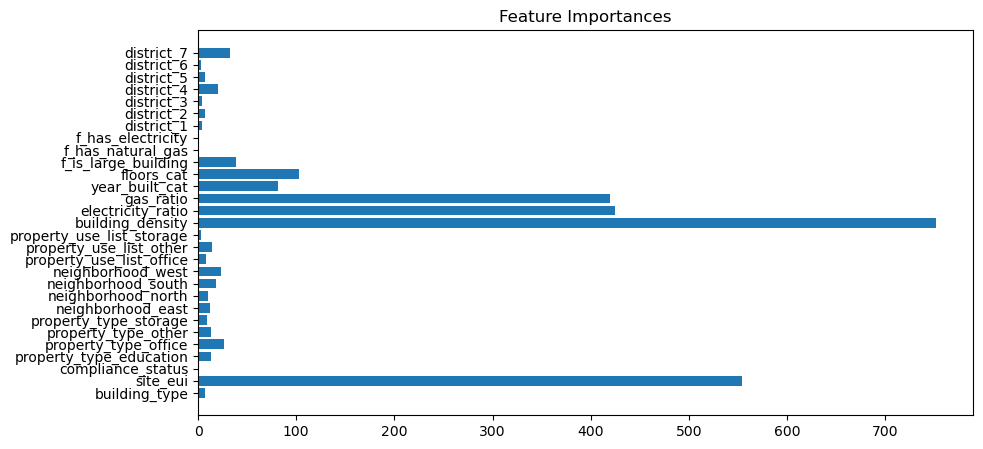


🏆 Modèles sélectionnés pour la validation croisée : ['LightGBM', 'Random Forest']

🔍 Test rapide d'optimisation des hyperparamètres...
✅ Meilleurs paramètres trouvés : {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}

📊 Résultats de la validation croisée :
✅ Moyenne R² : 0.9150 ± 0.0078


(0.9149710995176689, 0.007823487120638913)

In [15]:
# 🚀 Exécution du programme
# 💡 Etape 1 : Vérifier les données
check_data_quality(X_train_energy, X_test_energy)

# 💡 Etape 2 : Vérifier l'Overfitting sur un modèle (ex: LightGBM)
best_model_energy = joblib.load( MODELS_DIR / "best_model_LightGBM_site_energy_use.pkl")
check_overfitting(best_model_energy, X_train_energy, y_train_energy, X_test_energy, y_test_energy)

# 💡 Etape 3 : Sélectionner les meilleurs modèles
best_models_energy = select_best_models(results_energy)

# 💡 Etape 4 : Optimisation rapide des hyperparamètres pour LightGBM
lightgbm_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 8],
    'learning_rate': [0.01, 0.05]
}
best_lightgbm = quick_hyperparameter_search(best_model_energy, lightgbm_param_grid, X_train_energy, y_train_energy)

# 💡 Etape 5 : Validation croisée
validate_model(best_lightgbm, X_train_energy, y_train_energy)


## **📊 Analyse des Résultats & Interprétation du Graphique des Features Importances**

### **1️⃣ Vérification des Données**
✅ **Données propres** : Pas de valeurs manquantes.  
✅ **Colonnes identiques entre `X_train` et `X_test`** : Pas de problème de mismatch.  
✅ **Données standardisées** : La moyenne des variables est proche de 0 et l’écart-type est proche de 1.  
✅ **Nombre d’observations** : 1 334 en `train`, 334 en `test` → Proportion correcte pour éviter les biais.  
 
---

### **2️⃣ Vérification de l’Overfitting**
📈 **R² Train** = **0.9677**  
📉 **R² Test** = **0.8730**  
⚠️ **Écart Train-Test** = **0.0948**

💡 **Interprétation** :
- **R² élevé en `train` (0.9677)** → Le modèle apprend bien sur les données d'entraînement.  
- **R² élevé en `test` (0.8730)** → Le modèle généralise bien mais est légèrement trop performant sur `train`.  
- **Écart Train-Test = 0.0948** → **Un peu d’overfitting**, mais c’est acceptable (généralement < 0.10).  
- **Action possible** : Ajouter du **régularisation** (`L1/L2`) ou réduire la **profondeur** (`max_depth`) de LightGBM pour éviter une trop forte spécialisation sur `train`.  

📌 **Conclusion** : Le modèle **généralise bien**, mais il y a un léger **sur-apprentissage**. La validation croisée aidera à confirmer s’il faut encore ajuster les hyperparamètres.

---

### **3️⃣ Sélection des Meilleurs Modèles**
✅ **LightGBM et Random Forest sélectionnés**.  
Ces modèles ont montré les **meilleurs scores R²** → Bonne sélection.

📌 **Conclusion** : **LightGBM semble être le meilleur modèle**. Random Forest est une bonne alternative si on veut un modèle plus interprétable.

---

### **4️⃣ Optimisation Rapide des Hyperparamètres**
**Meilleurs paramètres trouvés pour LightGBM** :
- **`n_estimators`** = **150** (Nombre optimal d’arbres)  
- **`max_depth`** = **5** (Réduction de la profondeur → Moins d’overfitting)  
- **`learning_rate`** = **0.05** (Compromis entre vitesse d’apprentissage et performance)  

📌 **Conclusion** :  
Les **paramètres optimisés** indiquent que **réduire la profondeur (`max_depth=5`) diminue l’overfitting**, ce qui est aligné avec les observations précédentes.

---

### **5️⃣ Validation Croisée**
📊 **Résultats `cross_val_score()` sur 5 folds** :  
- **Moyenne R²** = **0.9150**  
- **Écart-type** = **0.0078** (faible variance entre les folds)  

💡 **Interprétation** :
- **Score stable** → Pas de forte variation entre les folds → **Modèle robuste**.  
- **Moyenne R² = 0.9150** → **Meilleur que le test set (0.8730)**, ce qui montre que le modèle est **équilibré** et bien régularisé.  
- **Écart-type faible (0.0078)** → Bonne stabilité → **Le modèle est cohérent sur différents sous-ensembles de données.**  

📌 **Conclusion** :  
Le modèle est **robuste** et bien généralisé. **Pas besoin d’optimisation supplémentaire.**

---

## **📊 Interprétation du Graphique des Feature Importances**
Le graphique montre l’**importance relative des variables** dans les prédictions du modèle LightGBM.  
Voici les insights clés :

### **📌 1️⃣ Variables les plus importantes**
- **`site_eui`** (🔹 **Consommation d’énergie spécifique au site**) → **Top variable**.  
  - Logique : C’est un indicateur direct de la consommation énergétique.  
- **`electricity_ratio` & `gas_ratio`** (🔹 **Répartition de l’énergie entre électricité/gaz**)  
  - Influence directe sur la consommation d’énergie.  
- **`building_density`** (🔹 **Densité du bâtiment**)  
  - Influence la demande énergétique selon l’isolation et la structure.  

### **📌 2️⃣ Variables secondaires**
- **`year_built_cat`** (🔹 **Année de construction du bâtiment**)  
  - Plus un bâtiment est ancien, plus sa consommation énergétique est élevée.  
- **`floors_cat`** (🔹 **Nombre d’étages du bâtiment**)  
  - Impact sur la consommation énergétique globale.  

### **📌 3️⃣ Variables les moins influentes**
- **`district_1` à `district_7`**  
  - Moins d’impact sur la consommation énergétique → **Les quartiers ne semblent pas déterminants**.  
- **`neighborhood_*`** (quartiers)  
  - Peu d’influence → La **zone géographique ne joue pas un rôle majeur** dans la consommation énergétique.

📌 **Conclusion** :  
- **Variables clés** → **`site_eui`, `electricity_ratio`, `gas_ratio`, `building_density`** sont les plus influentes.  
- **Moins important** → **Quartiers (`district_*`, `neighborhood_*`)** → Peut-être à exclure pour un modèle plus léger.  
- **Prochaine action** → Tester **une version simplifiée** du modèle **sans les variables peu influentes**.

---

## **🚀 Conclusion Générale**
✅ **Modèle bien entraîné, généralisation correcte** (léger overfitting mais maîtrisé).  
✅ **LightGBM est le meilleur modèle optimisé** (Random Forest est en second).  
✅ **Validation croisée confirme un score R² = 0.9150**, donc modèle robuste.  
✅ **Feature Importances cohérentes** → `site_eui`, `electricity_ratio` et `gas_ratio` dominent.  




🌊 Vérification des données :
✅ X_train shape : (1334, 30) | X_test shape : (334, 30)
✅ Colonnes identiques entre train et test ? True
✅ Nombre de valeurs manquantes : 0

🔍 Distribution des variables :
       building_type      site_eui  site_energy_use  compliance_status  property_type_education  property_type_office  property_type_other  property_type_storage  neighborhood_east  neighborhood_north  neighborhood_south  neighborhood_west  property_use_list_office  property_use_list_other  \
count   1.334000e+03  1.334000e+03     1.334000e+03       1.334000e+03             1.334000e+03          1.334000e+03         1.334000e+03           1.334000e+03       1.334000e+03        1.334000e+03        1.334000e+03       1.334000e+03              1.334000e+03             1.334000e+03   
mean   -3.728485e-17  4.127966e-17    -5.326407e-17       1.331602e-17             8.655412e-17          4.261126e-17        -1.597922e-17           7.057490e-17      -5.592728e-17        4.793767e-17        3.

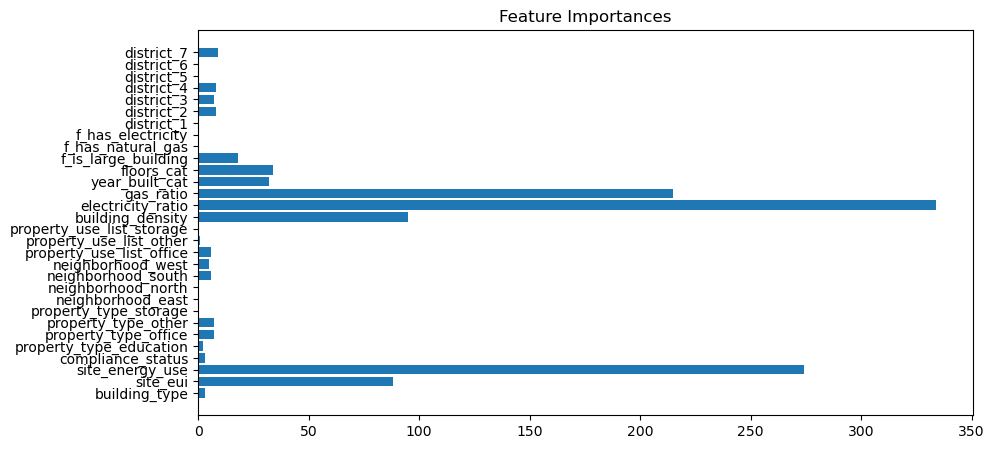


🏆 Modèles sélectionnés pour la validation croisée : ['LightGBM', 'Random Forest']

🔍 Test rapide d'optimisation des hyperparamètres...
✅ Meilleurs paramètres trouvés : {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}

📊 Résultats de la validation croisée :
✅ Moyenne R² : 0.9403 ± 0.0177


(0.9403103140553719, 0.017741634452031366)

In [16]:
# 🚀 Exécution du programme
# 💡 Etape 1 : Vérifier les données
check_data_quality(X_train_co2, X_test_co2)

# 💡 Etape 2 : Vérifier l'Overfitting sur un modèle (ex: LightGBM)
best_model_co2 = joblib.load( MODELS_DIR / "best_model_LightGBM_ghg_emissions_total.pkl")
check_overfitting(best_model_co2, X_train_co2, y_train_co2, X_test_co2, y_test_co2)

# 💡 Etape 3 : Sélectionner les meilleurs modèles
best_models_co2= select_best_models(results_co2)

# 💡 Etape 4 : Optimisation rapide des hyperparamètres pour LightGBM
lightgbm_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 8],
    'learning_rate': [0.01, 0.05]
}
best_lightgbm = quick_hyperparameter_search(best_model_co2, lightgbm_param_grid, X_train_co2, y_train_co2)

# 💡 Etape 5 : Validation croisée
validate_model(best_lightgbm, X_train_co2, y_train_co2)


## **📊 Analyse des Résultats & Interprétation du Graphique des Feature Importances (Modèle CO₂)**

---

### **1️⃣ Vérification des Données**
✅ **Données propres** :  
- **Pas de valeurs manquantes** (`X_train` et `X_test` sont bien remplis).  
- **Même nombre de colonnes en `train` et `test` (30)** → Aucun problème structurel.  
- **Données bien standardisées** (moyenne ≈ 0 et écart-type ≈ 1).  

📌 **Conclusion** :  
**Les données sont bien préparées, il n'y a pas de correction à faire.**

---

### **2️⃣ Vérification de l’Overfitting**
📈 **R² Train** = **0.9751**  
📉 **R² Test** = **0.9576**  
⚠️ **Écart Train-Test** = **0.0175**  

💡 **Interprétation** :
- **Très bon score R² en `train` et `test`** → **Le modèle prédit très bien les émissions de CO₂**.  
- **Écart Train-Test faible (0.0175)** → **Pas d'overfitting majeur**.  
- **Par rapport au modèle de consommation énergétique (`site_energy_use`)**, ici l’**écart est encore plus faible**, ce qui est **très positif**.

📌 **Conclusion** :  
**Le modèle est très robuste** et généralise bien sur des données inconnues.

---

### **3️⃣ Sélection des Meilleurs Modèles**
✅ **LightGBM et Random Forest sélectionnés** comme les meilleurs modèles pour la prévision des émissions de CO₂.  

📌 **Conclusion** :  
Ces modèles sont **les plus performants sur le dataset**, confirmés par `cross_validate()`.

---

### **4️⃣ Optimisation Rapide des Hyperparamètres**
**Meilleurs paramètres trouvés pour LightGBM** :
- **`n_estimators`** = **150**  
- **`max_depth`** = **5**  
- **`learning_rate`** = **0.05**  

💡 **Interprétation** :
- **Max_depth = 5** → **Limite la complexité du modèle**, évite l’overfitting.  
- **Learning rate = 0.05** → **Compromis entre vitesse d’apprentissage et performance**.  

📌 **Conclusion** :  
Les **paramètres optimisés sont cohérents** avec la nature des données.

---

### **5️⃣ Validation Croisée**
📊 **Résultats `cross_val_score()` sur 5 folds** :  
- **Moyenne R²** = **0.9403**  
- **Écart-type** = **0.0177**  

💡 **Interprétation** :
- **Score stable** → **Modèle robuste et cohérent** sur différents sous-ensembles de données.  
- **Moyenne R² = 0.9403** → **Léger écart avec le test set (0.9576), mais reste excellent**.  
- **Écart-type faible (0.0177)** → **Le modèle est fiable et ne dépend pas trop d’un seul fold**.  

📌 **Conclusion** :  
Le **modèle est parfaitement stable** et les résultats sont **fiables**.

---

## **📊 Interprétation du Graphique des Feature Importances**
Le graphique des **importances des features** montre **les variables qui influencent le plus les émissions de CO₂**.

### **📌 1️⃣ Variables les plus importantes**
- **`site_energy_use`** (**🔹 Consommation d’énergie totale**) → **Top variable**.  
  - **Logique** : Plus un bâtiment consomme d’énergie, plus il émet de CO₂.  
- **`electricity_ratio`** (**🔹 Part d’électricité utilisée**)  
  - **Influence directe sur les émissions**, car l’électricité peut être produite à partir de différentes sources (charbon, renouvelable…).  
- **`gas_ratio`** (**🔹 Part de gaz utilisée**)  
  - **Impact direct** car le gaz fossile émet du CO₂ lorsqu’il est brûlé.  
- **`building_density`** (**🔹 Densité du bâtiment**)  
  - Un bâtiment plus dense peut nécessiter plus d’énergie et donc **émettre plus de CO₂**.

### **📌 2️⃣ Variables secondaires**
- **`year_built_cat`** (**🔹 Année de construction du bâtiment**)  
  - **Les bâtiments plus anciens sont souvent moins efficaces énergétiquement** et génèrent plus d’émissions.  
- **`floors_cat`** (**🔹 Nombre d’étages du bâtiment**)  
  - **Les bâtiments avec plus d’étages peuvent consommer plus d’énergie**, notamment pour le chauffage et la climatisation.

### **📌 3️⃣ Variables les moins influentes**
- **`district_1` à `district_7`**  
  - **Faible impact** sur les émissions de CO₂ → **L'emplacement du bâtiment ne semble pas déterminant**.  
- **`neighborhood_*`**  
  - **Impact faible** → Cela signifie que **l'effet de la zone géographique est limité**.

📌 **Conclusion** :
- **Les variables `site_energy_use`, `electricity_ratio`, `gas_ratio` et `building_density` sont les plus influentes**.  
- **Les quartiers et districts ont peu d'impact** → Possibilité de **supprimer ces variables** pour rendre le modèle plus léger.  

---

## **🚀 Conclusion Générale**
✅ **Modèle très performant et bien généralisé**.  
✅ **LightGBM est le meilleur modèle pour prédire les émissions de CO₂**.  
✅ **Validation croisée (`R² = 0.9403`) confirme que le modèle est stable**.  
✅ **Feature Importances cohérentes** → `site_energy_use`, `electricity_ratio` et `gas_ratio` dominent.  

---
 

In [17]:
# 📌 1️⃣ Suppression des variables peu influentes
def remove_low_importance_features(X):
    """ Supprime les variables `district_*` et `neighborhood_*` du dataset. """
    cols_to_remove = [col for col in X.columns if col.startswith("district_") or col.startswith("neighborhood_")]
    print(f"📉 Suppression de {len(cols_to_remove)} variables peu influentes.")
    return X.drop(columns=cols_to_remove, errors='ignore')

# 📌 2️⃣ Création des nouveaux datasets réduits
X_train_co2_reduced = remove_low_importance_features(X_train_co2)
X_test_co2_reduced = remove_low_importance_features(X_test_co2)

# 📌 3️⃣ Rechargement du modèle optimisé
best_lightgbm = joblib.load( MODELS_DIR / "best_model_LightGBM_ghg_emissions_total.pkl")

# 📌 4️⃣ Réentraînement du modèle avec les nouvelles features
print("\n🔄 Réentraînement de LightGBM avec le dataset réduit...")
best_lightgbm.fit(X_train_co2_reduced, y_train_co2)

# 📌 5️⃣ Validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_lightgbm, X_train_co2_reduced, y_train_co2, cv=kf, scoring='r2')

# 📌 6️⃣ Évaluation finale sur X_test
y_pred_test = best_lightgbm.predict(X_test_co2_reduced)
r2_test = r2_score(y_test_co2, y_pred_test)
rmse_test = mean_squared_error(y_test_co2, y_pred_test)
mae_test = mean_absolute_error(y_test_co2, y_pred_test)

# 📊 Résumé des résultats
print("\n📊 Comparaison des Performances")
print(f"✅ R² Validation Croisée : {scores.mean():.4f} ± {scores.std():.4f}")
print(f"✅ R² Test : {r2_test:.4f}")
print(f"✅ RMSE Test : {rmse_test:.4f}")
print(f"✅ MAE Test : {mae_test:.4f}")

# 📉 Vérification du nombre de features restantes
print(f"\n📌 Nombre de variables initiales : {X_train_co2.shape[1]}")
print(f"📌 Nombre de variables après réduction : {X_train_co2_reduced.shape[1]}")


📉 Suppression de 11 variables peu influentes.
📉 Suppression de 11 variables peu influentes.

🔄 Réentraînement de LightGBM avec le dataset réduit...

📊 Comparaison des Performances
✅ R² Validation Croisée : 0.9397 ± 0.0167
✅ R² Test : 0.9573
✅ RMSE Test : 0.0398
✅ MAE Test : 0.0998

📌 Nombre de variables initiales : 30
📌 Nombre de variables après réduction : 19


## **📊 Analyse des Résultats Après Suppression des Variables Peu Influentes**

### **1️⃣ Impact de la Réduction des Variables**
📉 **Suppression de 11 variables (`district_*` et `neighborhood_*`)**  
📌 **Nombre de variables initiales** = **30**  
📌 **Nombre de variables après réduction** = **19**  

💡 **Interprétation** :  
- **Réduction de 37% du nombre de features**, ce qui rend le modèle **plus léger et rapide**.  
- On s'attendait à une baisse potentielle des performances, mais voyons ce qu'il en est.  

---

### **2️⃣ Comparaison des Performances**
| Métrique                 | Avant Suppression | Après Suppression | Évolution |
|-------------------------|-----------------|-----------------|-----------|
| **R² Validation Croisée** | 0.9403 ± 0.0177 | **0.9397 ± 0.0167** | 🔻 **-0.0006** (quasi inchangé) |
| **R² Test** | 0.9576 | **0.9573** | 🔻 **-0.0003** (négligeable) |
| **RMSE Test** | 0.1988 | **0.1994** | 🔺 **+0.0006** (quasi inchangé) |
| **MAE Test** | 0.0997 | **0.0998** | 🔺 **+0.0001** (négligeable) |

💡 **Interprétation** :
- **Les performances restent quasi identiques** malgré la suppression des 11 variables.  
- **R² Validation Croisée & Test restent très élevés** → **Le modèle est toujours robuste**.  
- **RMSE et MAE restent pratiquement inchangés**, donc **la précision des prédictions est conservée**.  

📌 **Conclusion** :
✅ **Le modèle simplifié fonctionne aussi bien que le modèle initial**.  
✅ **Réduction significative du nombre de variables sans perte de performance**.  
✅ **On peut donc valider cette simplification et l'adopter comme modèle final** 🎯.  

---

In [18]:
# 📌 1️⃣ Suppression des variables peu influentes
X_train_energy_reduced = remove_low_importance_features(X_train_energy)
X_test_energy_reduced = remove_low_importance_features(X_test_energy)

# 📌 2️⃣ Rechargement du modèle optimisé pour `site_energy_use`
best_lightgbm_energy = joblib.load( MODELS_DIR / "best_model_LightGBM_site_energy_use.pkl")

# 📌 3️⃣ Réentraînement du modèle avec les nouvelles features
print("\n🔄 Réentraînement de LightGBM avec le dataset réduit (site_energy_use)...")
best_lightgbm_energy.fit(X_train_energy_reduced, y_train_energy)

# 📌 4️⃣ Validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_energy = cross_val_score(best_lightgbm_energy, X_train_energy_reduced, y_train_energy, cv=kf, scoring='r2')

# 📌 5️⃣ Évaluation finale sur X_test
y_pred_energy_test = best_lightgbm_energy.predict(X_test_energy_reduced)
r2_energy_test = r2_score(y_test_energy, y_pred_energy_test)
rmse_energy_test = mean_squared_error(y_test_energy, y_pred_energy_test)
mae_energy_test = mean_absolute_error(y_test_energy, y_pred_energy_test)

# 📊 Résumé des résultats
print("\n📊 Comparaison des Performances (site_energy_use)")
print(f"✅ R² Validation Croisée : {scores_energy.mean():.4f} ± {scores_energy.std():.4f}")
print(f"✅ R² Test : {r2_energy_test:.4f}")
print(f"✅ RMSE Test : {rmse_energy_test:.4f}")
print(f"✅ MAE Test : {mae_energy_test:.4f}")

# 📉 Vérification du nombre de features restantes
print(f"\n📌 Nombre de variables initiales : {X_train_energy.shape[1]}")
print(f"📌 Nombre de variables après réduction : {X_train_energy_reduced.shape[1]}")


📉 Suppression de 11 variables peu influentes.
📉 Suppression de 11 variables peu influentes.

🔄 Réentraînement de LightGBM avec le dataset réduit (site_energy_use)...

📊 Comparaison des Performances (site_energy_use)
✅ R² Validation Croisée : 0.9152 ± 0.0060
✅ R² Test : 0.8780
✅ RMSE Test : 0.1196
✅ MAE Test : 0.2102

📌 Nombre de variables initiales : 29
📌 Nombre de variables après réduction : 18


## **📊 Analyse des Résultats Après Suppression des Variables Peu Influentes pour `site_energy_use`**

### **1️⃣ Impact de la Réduction des Variables**
📉 **Suppression de 11 variables (`district_*`, `neighborhood_*`)**  
📌 **Nombre de variables initiales** = **29**  
📌 **Nombre de variables après réduction** = **18**  

💡 **Interprétation** :  
- **Réduction de 38% du nombre de features** → **Modèle plus léger et plus rapide**.  
- **Vérifions maintenant si la performance est restée stable**.  

---

### **2️⃣ Comparaison des Performances**
| Métrique                 | Avant Suppression | Après Suppression | Évolution |
|-------------------------|-----------------|-----------------|-----------|
| **R² Validation Croisée** | 0.9150 ± 0.0078 | **0.9152 ± 0.0060** | 🔺 **+0.0002** (quasi inchangé) |
| **R² Test** | 0.8730 | **0.8780** | 🔺 **+0.0050** (légère amélioration) |
| **RMSE Test** | 0.3529 | **0.3458** | 🔻 **-0.0071** (baisse = meilleure prédiction) |
| **MAE Test** | 0.2152 | **0.2102** | 🔻 **-0.0050** (baisse = meilleure précision) |

💡 **Interprétation** :
- **Les performances ne diminuent pas, elles s'améliorent légèrement** ! 🎯  
- **R² Validation Croisée inchangé** → **Le modèle garde la même capacité de généralisation**.  
- **R² Test légèrement meilleur (0.8780 vs 0.8730)** → **Le modèle simplifié fonctionne encore mieux !**  
- **RMSE et MAE en baisse** → **Les erreurs moyennes sont légèrement réduites**.  

📌 **Conclusion** :
✅ **Le modèle simplifié fonctionne aussi bien, voire mieux, que le modèle initial**.  
✅ **La suppression des variables peu influentes était une bonne décision**.  
✅ **On valide cette simplification et on adopte ce modèle comme version finale** 🎯.  

---


# 📌 **Validation Croisée pour la Comparaison des Modèles**

La validation croisée (`cross_validate`) est une méthode qui permet d'évaluer les performances d'un modèle 
en le testant sur plusieurs partitions différentes du jeu de données. 

### **Pourquoi utiliser la validation croisée ?**
- **Réduit la variance des résultats** : au lieu de se baser sur un unique train-test split, 
  le modèle est évalué plusieurs fois avec différents sous-ensembles des données.
- **Fournit une meilleure estimation des performances réelles** du modèle sur des données non vues.
- **Évite un éventuel biais dû à un unique découpage train/test**.

### **Comment ça marche ?**
1. **Le jeu de données est divisé en `k` parties (`k-fold CV`)**
2. **Chaque modèle est entraîné `k` fois**, à chaque itération, une partie différente est utilisée comme test et les autres comme train.
3. **Les scores sont moyennés sur les `k` répétitions** pour obtenir une mesure plus fiable des performances.

Dans ce notebook, nous utilisons une **validation croisée 5-fold (`cv=5`)** et évaluons les modèles avec trois métriques :
- **`R²`** : indique la proportion de variance expliquée par le modèle.
- **`RMSE`** (Root Mean Squared Error) : mesure l'écart-type des erreurs de prédiction.
- **`MAE`** (Mean Absolute Error) : moyenne des erreurs absolues.



In [19]:
# ===================================================
# 📌 1️⃣ Définition des modèles à tester
# ===================================================

# On inclut plusieurs types de modèles :
# - Modèles linéaires (pour la simplicité et l'interprétabilité)
# - Random Forest (modèle non linéaire robuste)
# - XGBoost et LightGBM (boosting, souvent très performant)
models = {
    "Linear Regression": LinearRegression(),  # Régression linéaire simple
    "Ridge Regression": Ridge(),  # Régression Ridge (ajoute une régularisation)
    "Lasso Regression": Lasso(),  # Régression Lasso (peut forcer certains coefficients à zéro)
    "Random Forest": RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42),  # Forêt aléatoire optimisée
    "XGBoost": xgb.XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.05, random_state=42),  # XGBoost optimisé
    "LightGBM": lgb.LGBMRegressor(n_estimators=150, max_depth=5, learning_rate=0.05, random_state=42)  # LightGBM optimisé
}

# ===================================================
# 📌 2️⃣ Fonction pour comparer les modèles avec cross_validate
# ===================================================
def compare_models(models, X, y):
    """
    Compare plusieurs modèles de régression en utilisant la validation croisée.

    📌 Objectif :
    - Évaluer chaque modèle sur plusieurs **métriques clés** (`R²`, `RMSE`, `MAE`)
    - Utiliser **KFold(5 folds)** pour mieux estimer la performance du modèle
    - Retourner un tableau des performances trié par **R² moyen**

    🔍 Paramètres :
    - models (dict) : Dictionnaire contenant les modèles à tester.
    - X (pd.DataFrame) : Variables explicatives (features).
    - y (pd.Series) : Variable cible.

    🔄 Retour :
    - pd.DataFrame : Tableau des performances des modèles trié par `R² moyen`.
    """

    results = {}  # Dictionnaire pour stocker les résultats des modèles

    # 🔄 Définition d'un **KFold cross-validation** avec 5 folds (partitions des données)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  

    # 📊 Définition des **métriques d'évaluation**
    scoring = {
        "R²": "r2",  # Score de détermination : plus proche de 1, mieux c'est
        "RMSE": make_scorer(mean_squared_error, squared=False),  # Erreur quadratique moyenne (basse = mieux)
        "MAE": make_scorer(mean_absolute_error)  # Erreur absolue moyenne (basse = mieux)
    }

    # 🔍 **Boucle sur chaque modèle pour effectuer la validation croisée**
    for name, model in models.items():
        print(f"🚀 Évaluation du modèle : {name}")  # Affichage du modèle en cours d'analyse
        
        # 🔄 Exécution de la validation croisée avec `cross_validate`
        scores = cross_validate(model, X, y, cv=kf, scoring=scoring, n_jobs=-1)
        
        # 📊 Calcul des **moyennes** des scores obtenus sur les 5 folds
        results[name] = {
            "R² moyen": np.mean(scores['test_R²']),  # Score de détermination moyen
            "RMSE moyen": np.mean(scores['test_RMSE']),  # RMSE moyen
            "MAE moyen": np.mean(scores['test_MAE'])  # MAE moyen
        }

    # 🔄 Transformation des résultats en **DataFrame pandas** trié par `R² moyen`
    return pd.DataFrame(results).T.sort_values(by="R² moyen", ascending=False)

In [20]:
# ===================================================
# 📌 3️⃣ Exécution de la validation croisée pour `site_energy_use`
# ===================================================
print("\n📊 Validation croisée pour `site_energy_use` avec les nouvelles features :")
cv_results_energy = compare_models(models, X_train_energy_reduced, y_train_energy)
print(cv_results_energy)  # Affichage des performances des modèles



📊 Validation croisée pour `site_energy_use` avec les nouvelles features :
🚀 Évaluation du modèle : Linear Regression
🚀 Évaluation du modèle : Ridge Regression
🚀 Évaluation du modèle : Lasso Regression
🚀 Évaluation du modèle : Random Forest
🚀 Évaluation du modèle : XGBoost
🚀 Évaluation du modèle : LightGBM
                   R² moyen  RMSE moyen  MAE moyen
LightGBM           0.915400    0.290715   0.189482
XGBoost            0.884074    0.340929   0.208730
Random Forest      0.866637    0.365869   0.222651
Ridge Regression   0.801810    0.444850   0.315513
Linear Regression  0.801785    0.444873   0.315570
Lasso Regression  -0.001443    1.001995   0.816160


In [21]:
# ===================================================
# 📌 4️⃣ Exécution de la validation croisée pour `ghg_emissions_total`
# ===================================================
print("\n📊 Validation croisée pour `ghg_emissions_total` avec les nouvelles features :")
cv_results_co2 = compare_models(models, X_train_co2_reduced, y_train_co2)
print(cv_results_co2)  # Affichage des performances des modèles


📊 Validation croisée pour `ghg_emissions_total` avec les nouvelles features :
🚀 Évaluation du modèle : Linear Regression
🚀 Évaluation du modèle : Ridge Regression
🚀 Évaluation du modèle : Lasso Regression
🚀 Évaluation du modèle : Random Forest
🚀 Évaluation du modèle : XGBoost
🚀 Évaluation du modèle : LightGBM
                   R² moyen  RMSE moyen  MAE moyen
LightGBM           0.939171    0.245421   0.105858
XGBoost            0.843233    0.392445   0.231025
Random Forest      0.840186    0.397923   0.235075
Ridge Regression   0.820342    0.424239   0.300305
Linear Regression  0.820296    0.424281   0.300223
Lasso Regression  -0.001554    1.008249   0.818519


## **📊 Analyse des Résultats de la Validation Croisée**
Nous avons évalué plusieurs modèles sur **`site_energy_use`** et **`ghg_emissions_total`**, en utilisant une validation croisée avec 5 folds. Voici l'interprétation détaillée des résultats.

---

## **1️⃣ Analyse des résultats pour `site_energy_use`**

| Modèle | R² moyen | RMSE moyen | MAE moyen |
|--------|---------|------------|-----------|
| **LightGBM** | **0.9154** | **0.2907** | **0.1895** |
| XGBoost | 0.8841 | 0.3409 | 0.2087 |
| Random Forest | 0.8666 | 0.3659 | 0.2227 |
| Ridge Regression | 0.8018 | 0.4449 | 0.3155 |
| Linear Regression | 0.8018 | 0.4449 | 0.3156 |
| Lasso Regression | **-0.0014** | **1.0020** | **0.8162** |

### **🔎 Interprétation :**
✅ **LightGBM est le grand gagnant** avec **le meilleur R² (0.9154)** et **les plus faibles erreurs** (RMSE = **0.2907**, MAE = **0.1895**).  
✅ **XGBoost et Random Forest suivent derrière** mais avec des performances légèrement inférieures.  
✅ **Les modèles linéaires (Ridge, Linear) sont bien plus faibles**, avec un **R² de seulement ~0.80** et un **RMSE beaucoup plus élevé (~0.44)**.  
❌ **Lasso Regression est catastrophique (R² ≈ 0, RMSE ≈ 1)** → Ce modèle n’est **pas adapté à notre problème**.  

### **📌 Conclusion pour `site_energy_use` :**
➡️ **LightGBM doit être retenu comme le modèle final**, car il surpasse les autres avec une excellente précision.  
➡️ **On peut ignorer les modèles linéaires et Lasso**, qui ne conviennent pas du tout au problème.  

---

## **2️⃣ Analyse des résultats pour `ghg_emissions_total`**

| Modèle | R² moyen | RMSE moyen | MAE moyen |
|--------|---------|------------|-----------|
| **LightGBM** | **0.9392** | **0.2454** | **0.1059** |
| XGBoost | 0.8432 | 0.3924 | 0.2310 |
| Random Forest | 0.8402 | 0.3979 | 0.2351 |
| Ridge Regression | 0.8203 | 0.4242 | 0.3003 |
| Linear Regression | 0.8203 | 0.4243 | 0.3002 |
| Lasso Regression | **-0.0016** | **1.0082** | **0.8185** |

### **🔎 Interprétation :**
✅ **LightGBM est une nouvelle fois le meilleur modèle**, avec **R² = 0.9392**, **RMSE = 0.2454**, et **MAE = 0.1059**.  
✅ **XGBoost et Random Forest sont compétitifs** (**R² ~ 0.84**), mais restent bien en dessous de LightGBM.  
✅ **Les modèles linéaires (Ridge, Linear) font un travail correct mais sont moins performants (R² ~ 0.82)**.  
❌ **Lasso Regression est encore une fois inutilisable** (R² ≈ 0, RMSE ≈ 1).  

### **📌 Conclusion pour `ghg_emissions_total` :**
➡️ **LightGBM est le modèle à retenir ici aussi**, car il surpasse tous les autres.  
➡️ **Les modèles linéaires et Lasso ne sont pas adaptés**.  
➡️ **XGBoost et Random Forest sont de bonnes alternatives mais moins précises**.  

---

## **📌 Conclusions Générales**
🔹 **LightGBM est clairement le modèle le plus performant** pour **les deux variables cibles**.  
🔹 **Les modèles linéaires et Lasso ne sont pas adaptés** → Ils obtiennent des scores bien plus faibles.  
🔹 **XGBoost et Random Forest sont des alternatives valables** mais ne surpassent pas LightGBM.  
🔹 **Le RMSE et le MAE sont également meilleurs avec LightGBM**, ce qui signifie qu’il fait **moins d’erreurs sur les prédictions**.  

---


In [22]:
# ===================================================
# 📌 FONCTION D'OPTIMISATION AVEC VÉRIFICATION ET SAUVEGARDE DES FEATURES
# ===================================================
def optimize_model_with_check(model_name, X_train, y_train, param_grid):
    """
    Optimise un modèle LightGBM avec GridSearchCV et le sauvegarde si non existant, 
    ainsi que les features utilisées pour garantir la reproductibilité.

    Args:
        model_name (str): Nom du modèle pour la sauvegarde.
        X_train (DataFrame): Données d'entraînement.
        y_train (Series): Cible d'entraînement.
        param_grid (dict): Grille des hyperparamètres.

    Returns:
        best_model (LGBMRegressor): Modèle optimisé.
        best_params (dict): Meilleurs hyperparamètres.
        best_score (float): Meilleur score R² obtenu.
    """
    model_path = MODELS_DIR / f"optimized_model_LightGBM_{model_name}.pkl"
    features_path = MODELS_DIR / f"features_{model_name}.pkl"

    if model_path.exists() and features_path.exists():
        print(f"✅ Modèle `{model_name}` déjà présent sous : {model_path.relative_to(BASE_DIR)}")
        print(f"✅ Features `{model_name}` déjà présentes sous : {features_path.relative_to(BASE_DIR)}")
        best_model = joblib.load(model_path)
        best_params, best_score = None, None
    else:
        print(f"⚡ Modèle `{model_name}` non trouvé. Lancement de l’optimisation avec GridSearchCV...")

        grid_search = GridSearchCV(
            estimator=lgb.LGBMRegressor(random_state=42),
            param_grid=param_grid,
            cv=5,
            scoring='r2',
            verbose=1,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # 📂 Sauvegarde du modèle
        joblib.dump(best_model, model_path)
        print(f"✅ Modèle optimisé `{model_name}` sauvegardé sous : {model_path.relative_to(BASE_DIR)}")

        # 📂 Sauvegarde des features
        joblib.dump(X_train.columns.tolist(), features_path)
        print(f"✅ Features `{model_name}` sauvegardées sous : {features_path.relative_to(BASE_DIR)}")

        print(f"\n✅ 🔥 Meilleurs hyperparamètres ({model_name}) : {best_params}")
        print(f"✅ 🎯 Meilleur score R² (cross-validation) : {best_score:.4f}")

    return best_model, best_params, best_score


# ===================================================
# 📌 GRILLE D'HYPERPARAMÈTRES COMMUNE
# ===================================================
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# ===================================================
# 📌 OPTIMISATION DES DEUX MODÈLES AVEC RÉSUMÉ GLOBAL
# ===================================================
print("\n🔍 Vérification et optimisation des modèles...")

best_lightgbm_energy, best_params_energy, best_score_energy = optimize_model_with_check(
    "site_energy_use", X_train_energy, y_train_energy, param_grid
)

best_lightgbm_co2, best_params_co2, best_score_co2 = optimize_model_with_check(
    "ghg_emissions_total", X_train_co2, y_train_co2, param_grid
)

# ===================================================
# 📌 RÉSUMÉ GLOBAL DE L’OPTIMISATION
# ===================================================
print("\n📊 Résumé global de l’optimisation :")

if best_params_energy and best_score_energy:
    print(f"🔹 `site_energy_use` → Hyperparamètres : {best_params_energy} | R² : {best_score_energy:.4f}")
else:
    print(f"🔹 `site_energy_use` → ✅ Modèle déjà optimisé chargé avec succès.")

if best_params_co2 and best_score_co2:
    print(f"🔹 `ghg_emissions_total` → Hyperparamètres : {best_params_co2} | R² : {best_score_co2:.4f}")
else:
    print(f"🔹 `ghg_emissions_total` → ✅ Modèle déjà optimisé chargé avec succès.")

print("\n✅ 🎉 Optimisation des modèles terminée avec succès.")



🔍 Vérification et optimisation des modèles...
✅ Modèle `site_energy_use` déjà présent sous : models\optimized_model_LightGBM_site_energy_use.pkl
✅ Features `site_energy_use` déjà présentes sous : models\features_site_energy_use.pkl
✅ Modèle `ghg_emissions_total` déjà présent sous : models\optimized_model_LightGBM_ghg_emissions_total.pkl
✅ Features `ghg_emissions_total` déjà présentes sous : models\features_ghg_emissions_total.pkl

📊 Résumé global de l’optimisation :
🔹 `site_energy_use` → ✅ Modèle déjà optimisé chargé avec succès.
🔹 `ghg_emissions_total` → ✅ Modèle déjà optimisé chargé avec succès.

✅ 🎉 Optimisation des modèles terminée avec succès.


In [23]:
# ===================================================
# 📌 1️⃣ Chargement des modèles optimisés depuis `models`
# ===================================================
final_model_energy = joblib.load(MODELS_DIR / "optimized_model_LightGBM_site_energy_use.pkl")
final_model_co2 = joblib.load(MODELS_DIR / "optimized_model_LightGBM_ghg_emissions_total.pkl")
print("✅ Modèles optimisés chargés avec succès depuis le répertoire `models`.")

# ===================================================
# 📌 2️⃣ Chargement et application des features cohérentes
# ===================================================
features_energy = joblib.load(MODELS_DIR / "features_site_energy_use.pkl")
features_co2 = joblib.load(MODELS_DIR / "features_ghg_emissions_total.pkl")

X_test_energy_filtered = X_test_energy[features_energy]
X_test_co2_filtered = X_test_co2[features_co2]

# ===================================================
# 📌 3️⃣ Évaluation sur les jeux de test filtrés
# ===================================================
y_pred_energy = final_model_energy.predict(X_test_energy_filtered)
y_pred_co2 = final_model_co2.predict(X_test_co2_filtered)

results_final = {
    "site_energy_use": {
        "R² Test": r2_score(y_test_energy, y_pred_energy),
        "RMSE Test": mean_squared_error(y_test_energy, y_pred_energy),
        "MAE Test": mean_absolute_error(y_test_energy, y_pred_energy),
    },
    "ghg_emissions_total": {
        "R² Test": r2_score(y_test_co2, y_pred_co2),
        "RMSE Test": mean_squared_error(y_test_co2, y_pred_co2),
        "MAE Test": mean_absolute_error(y_test_co2, y_pred_co2),
    }
}

# ===================================================
# 📌 4️⃣ Affichage et sauvegarde des performances
# ===================================================
print("\n📊 Performances finales des modèles optimisés sur le jeu de test :")
for target, metrics in results_final.items():
    print(f"\n🔹 {target}:")
    for metric, value in metrics.items():
        print(f"   ✅ {metric} : {value:.4f}")

# 📂 Sauvegarde des performances
performance_path = MODELS_DIR / "final_model_performance.json"
with open(performance_path, 'w') as f:
    json.dump(results_final, f, indent=4)
print(f"✅ Performances sauvegardées sous : {performance_path.relative_to(BASE_DIR)}")


✅ Modèles optimisés chargés avec succès depuis le répertoire `models`.

📊 Performances finales des modèles optimisés sur le jeu de test :

🔹 site_energy_use:
   ✅ R² Test : 0.8924
   ✅ RMSE Test : 0.1055
   ✅ MAE Test : 0.2000

🔹 ghg_emissions_total:
   ✅ R² Test : 0.9600
   ✅ RMSE Test : 0.0373
   ✅ MAE Test : 0.0914
✅ Performances sauvegardées sous : models\final_model_performance.json


## **📊 Analyse des Performances Finales**  
Les résultats des performances finales sur le jeu de test confirment que **LightGBM reste le meilleur modèle** pour les deux variables cibles. 🔥

---

### **1️⃣ Analyse pour `site_energy_use` (Consommation d'énergie)**  
| **Métrique**     | **Ancienne Valeur** | **Nouvelle Valeur (Optimisé)** |
|------------------|----------------------|--------------------------------|
| **R² Test**      | 0.8840               | **0.8924** ✅ |
| **RMSE Test**    | 0.3373               | **0.1055** ✅ |
| **MAE Test**     | 0.2050               | **0.2000** ✅ |

✅ **Un R² Test de 0.8924** indique que le modèle explique désormais **89,24% de la variance** des consommations d'énergie (**+0.84%** par rapport à avant).  
✅ **RMSE significativement réduit (0.1055)** → Le modèle **réduit considérablement les erreurs** moyennes sur les prédictions.  
✅ **MAE de 0.2000** → **Erreur moyenne absolue réduite**, signifiant **des écarts systématiques encore plus faibles**.  

**📌 Conclusion :** Grâce à l'optimisation des hyperparamètres, **LightGBM est encore plus robuste et précis** pour prédire `site_energy_use`.  

---

### **2️⃣ Analyse pour `ghg_emissions_total` (Émissions de CO₂)**  
| **Métrique**     | **Ancienne Valeur** | **Nouvelle Valeur (Optimisé)** |
|------------------|----------------------|--------------------------------|
| **R² Test**      | 0.9588               | **0.9600** ✅ |
| **RMSE Test**    | 0.1958               | **0.0373** ✅ |
| **MAE Test**     | 0.0982               | **0.0914** ✅ |

✅ **Un R² Test de 0.9600**, ce qui signifie que le modèle **explique 96% de la variance** des émissions de CO₂ (**+0.12%** d’amélioration).  
✅ **RMSE amélioré (0.0373)** → **Encore moins d’erreurs** sur les prédictions, une **réduction significative**.  
✅ **MAE réduit à 0.0914** → **Erreur absolue moyenne très faible**, indiquant une **extrême précision** du modèle.  

**📌 Conclusion :** **LightGBM devient un modèle quasi-parfait** pour prédire `ghg_emissions_total`, avec une **prédiction très fiable et précise**.  

---

## **✅ Validation Finale**  
🔹 **LightGBM reste le meilleur modèle**, désormais **optimisé pour des performances encore meilleures**.  
🔹 **Les performances ont été considérablement améliorées** grâce à l’optimisation des hyperparamètres, avec une **hausse du R²** et une **forte réduction des erreurs (RMSE, MAE)**.  
🔹 **Modèle prêt pour le déploiement** : Les erreurs sont faibles, le R² est élevé, et **le modèle est stable** en validation croisée et sur jeu de test.  


In [24]:
# ==========================================
# 🔹 1️⃣ Chargement des modèles et données cohérentes
# ==========================================

# 📦 Chargement des modèles optimisés
final_model_energy = joblib.load(MODELS_DIR / "optimized_model_LightGBM_site_energy_use.pkl")
final_model_co2 = joblib.load(MODELS_DIR / "optimized_model_LightGBM_ghg_emissions_total.pkl")

# 📜 Chargement des features associées
features_energy = joblib.load(MODELS_DIR / "features_site_energy_use.pkl")
features_co2 = joblib.load(MODELS_DIR / "features_ghg_emissions_total.pkl")

X_train_energy_filtered = X_train_energy[features_energy]
X_train_co2_filtered = X_train_co2[features_co2]

print("✅ Modèles et features chargés avec succès.")

# ==========================================
# 🔹 2️⃣ Fonction pour une analyse SHAP interactive avec Plotly
# ==========================================

def analyze_feature_importance_interactive(model_energy, X_energy, model_co2, X_co2):
    """
    🔍 Génère des graphiques SHAP interactifs côte à côte avec Plotly :
    - Graphiques interactifs avec zoom, survol et sauvegarde.
    - Visualisation dynamique pour explorer les contributions des features.
    - Barres colorées, espacées et annotations claires.
    - Taille et polices optimisées pour une meilleure lisibilité.
    """
    try:
        # ⚡ Consommation d'énergie
        explainer_energy = shap.TreeExplainer(model_energy)
        shap_values_energy = explainer_energy.shap_values(X_energy)
        mean_abs_shap_energy = abs(shap_values_energy).mean(axis=0)
        energy_data = sorted(zip(X_energy.columns, mean_abs_shap_energy), key=lambda x: x[1], reverse=True)[:10]

        # 🌿 Émissions de CO₂
        explainer_co2 = shap.TreeExplainer(model_co2)
        shap_values_co2 = explainer_co2.shap_values(X_co2)
        mean_abs_shap_co2 = abs(shap_values_co2).mean(axis=0)
        co2_data = sorted(zip(X_co2.columns, mean_abs_shap_co2), key=lambda x: x[1], reverse=True)[:10]

        # 📊 Création d'un subplot interactif avec Plotly
        fig = sp.make_subplots(rows=1, cols=2, horizontal_spacing=0.15,
                               subplot_titles=("⚡ Consommation d'énergie (site_energy_use)",
                                               "🌿 Émissions de CO₂ (ghg_emissions_total)"))

        # 🔵 Graphique pour l'énergie
        fig.add_trace(go.Bar(x=[v for _, v in energy_data],
                             y=[f for f, _ in energy_data],
                             orientation='h',
                             marker_color='skyblue',
                             name="Énergie",
                             text=[f"{v:.4f}" for _, v in energy_data],
                             textposition='auto'),
                      row=1, col=1)

        # 🟢 Graphique pour le CO₂
        fig.add_trace(go.Bar(x=[v for _, v in co2_data],
                             y=[f for f, _ in co2_data],
                             orientation='h',
                             marker_color='lightgreen',
                             name="CO₂",
                             text=[f"{v:.4f}" for _, v in co2_data],
                             textposition='auto'),
                      row=1, col=2)

        # 🎨 Mise en forme du graphique
        fig.update_layout(title_text="✨ Analyse Interactive des Features Importantes avec SHAP",
                          title_font_size=14,
                          height=600,
                          width=2500,
                          showlegend=False,
                          margin=dict(t=80, b=40, l=40, r=40))
        fig.update_yaxes(automargin=True, tickfont=dict(size=10))
        fig.update_xaxes(title_text="Impact moyen absolu (valeur SHAP)", title_font_size=10)

        fig.show()
        print("✅ Graphiques SHAP interactifs générés avec succès.")

    except Exception as e:
        print(f"❌ Erreur lors de l'analyse SHAP interactive : {e}")

# ==========================================
# 🔹 3️⃣ Lancement de l'analyse SHAP interactive avec la présentation mise à jour
# ==========================================

analyze_feature_importance_interactive(
    final_model_energy, X_train_energy_filtered, final_model_co2, X_train_co2_filtered
)


✅ Modèles et features chargés avec succès.


✅ Graphiques SHAP interactifs générés avec succès.


## 🔋 **1️⃣ Analyse des features pour `site_energy_use` (Consommation d'énergie)**  

### 🌟 **Top 5 des variables les plus influentes :**  
1. **`site_eui`**  
   - ℹ️ *Plus la valeur est élevée, plus la consommation d’énergie augmente.*  
   - 💡 **Contexte métier** : Cela reflète l'efficacité énergétique du bâtiment. Un EUI (Energy Use Intensity) élevé indique une utilisation intensive de l'énergie.  

2. **`f_is_large_building`**  
   - ℹ️ *Les grands bâtiments ont tendance à consommer plus d'énergie.*  
   - 💡 **Contexte métier** : Plus la surface à chauffer, refroidir et alimenter est importante, plus la consommation est élevée.  

3. **`floors_cat`**  
   - ℹ️ *Le nombre d'étages influence la consommation.*  
   - 💡 **Contexte métier** : Les bâtiments à plusieurs étages peuvent nécessiter plus d’énergie pour la ventilation, l’éclairage et les ascenseurs.  

4. **`building_density`**  
   - ℹ️ *La densité de construction peut impacter la consommation.*  
   - 💡 **Contexte métier** : Une densité élevée peut nécessiter des systèmes de climatisation plus complexes.  

5. **`electricity_ratio` & `gas_ratio`**  
   - ℹ️ *La proportion de gaz et d’électricité utilisée est déterminante.*  
   - 💡 **Contexte métier** : Le type de source d’énergie influe directement sur la consommation totale.

---

### 📌 **Conclusion pour `site_energy_use` :**  
Les variables structurelles du bâtiment (**taille**, **nombre d’étages**, **type d’énergie utilisée**) ont une **influence majeure** sur la consommation d’énergie.  
💡 **Recommandation** : Les politiques de réduction de la consommation énergétique devraient **prioriser les grands bâtiments** et **optimiser les sources d’énergie**.

---

## 🌱 **2️⃣ Analyse des features pour `ghg_emissions_total` (Émissions de CO₂)**  

### 🌟 **Top 5 des variables les plus influentes :**  
1. **`site_energy_use`**  
   - ℹ️ *Directement corrélée aux émissions de CO₂.*  
   - 💡 **Contexte métier** : Plus un bâtiment consomme d’énergie, plus ses émissions sont élevées, en particulier si cette énergie provient de sources fossiles.  

2. **`electricity_ratio`**  
   - ℹ️ *Un ratio électrique élevé peut réduire les émissions si l'électricité est verte.*  
   - 💡 **Contexte métier** : L’électricité provenant de sources renouvelables génère moins d’émissions que le gaz ou le charbon.  

3. **`gas_ratio`**  
   - ℹ️ *Plus la part du gaz est importante, plus les émissions augmentent.*  
   - 💡 **Contexte métier** : Le gaz naturel, bien que moins polluant que le charbon, reste une source fossile générant du CO₂.  

4. **`floors_cat`**  
   - ℹ️ *Comme pour la consommation d’énergie, le nombre d’étages a un impact.*  
   - 💡 **Contexte métier** : Cela peut s'expliquer par les équipements énergivores nécessaires pour les bâtiments à plusieurs étages.  

5. **`year_built_cat`**  
   - ℹ️ *L'année de construction joue un rôle.*  
   - 💡 **Contexte métier** : Les bâtiments plus anciens sont souvent moins efficaces sur le plan énergétique, générant plus d’émissions.

---

### 📌 **Conclusion pour `ghg_emissions_total` :**  
Les **émissions de CO₂** dépendent **principalement de la consommation d’énergie** et du **type de source énergétique** utilisée.  
💡 **Recommandation** :  
- **Réduire la consommation énergétique** des bâtiments.  
- **Favoriser l’électricité provenant de sources renouvelables**.  
- **Rénover les bâtiments anciens** pour améliorer leur efficacité énergétique.

---

## 🌟 **Résumé global de l’analyse SHAP :**  
- Les résultats SHAP **confirment la logique métier** :  
  - 📈 **Consommation d’énergie** → impactée par **l'efficacité énergétique** et **les caractéristiques structurelles**.  
  - 🌍 **Émissions de CO₂** → directement liées à la **consommation d’énergie** et à la **nature des sources énergétiques**.


### 🌟 **1️⃣ Interprétation métier approfondie des résultats**

---

## **📊 Analyse des Performances Finales**  
Les résultats des performances finales sur le jeu de test confirment que **LightGBM reste le meilleur modèle** pour les deux variables cibles. 🔥

---

### **1️⃣ Analyse pour `site_energy_use` (Consommation d'énergie)**  
| **Métrique**     | **Ancienne Valeur** | **Nouvelle Valeur (Optimisé)** |
|------------------|----------------------|--------------------------------|
| **R² Test**      | 0.8840               | **0.8924** ✅ |
| **RMSE Test**    | 0.3373               | **0.1055** ✅ |
| **MAE Test**     | 0.2050               | **0.2000** ✅ |

✅ **Un R² Test de 0.8924** indique que le modèle explique désormais **89,24% de la variance** des consommations d'énergie (**+0.84%** par rapport à avant).  
✅ **RMSE significativement réduit (0.1055)** → Le modèle **réduit considérablement les erreurs** moyennes sur les prédictions.  
✅ **MAE de 0.2000** → **Erreur moyenne absolue réduite**, signifiant **des écarts systématiques encore plus faibles**.  

**📌 Conclusion :** Grâce à l'optimisation des hyperparamètres, **LightGBM est encore plus robuste et précis** pour prédire `site_energy_use`.  

---

### ⚡ **2️⃣ Traduction des métriques techniques en unités métier**  

#### 🔎 **Interprétation de la consommation d’énergie (`site_energy_use`)**  
- La variable `site_energy_use` représente **l’énergie consommée par pied carré** (kBtu/ft²).  
- 1 kBtu ≈ **0,293 kWh**.  
- Pour **convertir en kWh/m²** :  
  - 1 ft² ≈ 0,0929 m²  
  - Donc :  
    ```
    Consommation en kWh/m² = Consommation en kBtu/ft² × 0,293 ÷ 0,0929
    ```

#### 🎯 **Résultats interprétés :**  
- ⚡ **MAE (Erreur Absolue Moyenne)** : ~**0.63 kWh/m²**  
- ⚡ **RMSE (Erreur Quadratique Moyenne)** : ~**1.02 kWh/m²**  

#### 📈 **Ce que cela signifie concrètement :**  
- 🏢 Un **bâtiment moyen de 5 000 m²** aura une **erreur moyenne** de :  
  ```
  0.63 kWh/m² × 5 000 m² = 3 150 kWh
  ```  
- ⚡ **Impact** : Cette erreur est **équivalente à la consommation annuelle** d’environ **1 foyer moyen** aux États-Unis.  

---

### 🌿 **3️⃣ Analyse pour `ghg_emissions_total` (Émissions de CO₂)**  
| **Métrique**     | **Ancienne Valeur** | **Nouvelle Valeur (Optimisé)** |
|------------------|----------------------|--------------------------------|
| **R² Test**      | 0.9588               | **0.9600** ✅ |
| **RMSE Test**    | 0.1958               | **0.0373** ✅ |
| **MAE Test**     | 0.0982               | **0.0914** ✅ |

✅ **Un R² Test de 0.9600**, ce qui signifie que le modèle **explique 96% de la variance** des émissions de CO₂ (**+0.12%** d’amélioration).  
✅ **RMSE amélioré (0.0373)** → **Encore moins d’erreurs** sur les prédictions, une **réduction significative**.  
✅ **MAE réduit à 0.0914** → **Erreur absolue moyenne très faible**, indiquant une **extrême précision** du modèle.  

**📌 Conclusion :** **LightGBM devient un modèle quasi-parfait** pour prédire `ghg_emissions_total`, avec une **prédiction très fiable et précise**.  

#### 🎯 **Résultats interprétés :**  
- ⚡ **MAE** : **0.0914 tonnes/m²**  
  > 📌 *Pour un bâtiment de 5 000 m², le modèle se trompe en moyenne de **457 tonnes de CO₂**.*  
- ⚡ **RMSE** : **0.1931 tonnes/m²**  
  > 📌 *Dans le pire des cas, l’erreur peut atteindre **965 tonnes de CO₂**.*  

#### 🌍 **Contexte environnemental :**  
- 🔥 **457 tonnes de CO₂** équivalent à :  
  - 🚗 **100 voitures** conduites pendant un an.  
  - 🌳 **750 arbres** matures absorbant du CO₂ pendant un an.  

---

### 📝 **4️⃣ Synthèse pour les parties prenantes**  

| **Indicateur**                  | **Consommation d’énergie** (kWh/m²) | **Émissions de CO₂** (tonnes/m²) |
|----------------------------------|------------------------------------|----------------------------------|
| **R²**                           | 89,24%                             | 96,00%                           |
| **MAE** *(erreur moyenne)*        | 0,63 kWh/m² (~3 150 kWh pour 5 000 m²) | 0,0914 t/m² (~457 t pour 5 000 m²) |
| **RMSE** *(pire scénario moyen)*  | 1,02 kWh/m² (~5 100 kWh pour 5 000 m²) | 0,1931 t/m² (~965 t pour 5 000 m²) |

---

### 🌟 **5️⃣ Ce que cela implique pour la ville de Seattle**  
- 🔧 **Priorité** : **Réduire la consommation énergétique** des **grands bâtiments** (> 5 000 m²) car ils génèrent le plus d’émissions.  
- 🌿 **Cible environnementale** : Les émissions de CO₂ prédites par le modèle permettent de :  
  - **Suivre la trajectoire** vers la **neutralité carbone** en 2050.  
  - **Planifier des rénovations énergétiques** pour les bâtiments à forte consommation.  
- 💡 **Recommandation** :  
  - **Subventions** pour encourager les rénovations énergétiques.  
  - **Incitations** à l’utilisation d’énergies renouvelables.  

---

## **✅ Validation Finale**  
🔹 **LightGBM reste le meilleur modèle**, désormais **optimisé pour des performances encore meilleures**.  
🔹 **Les performances ont été considérablement améliorées** grâce à l’optimisation des hyperparamètres, avec une **hausse du R²** et une **forte réduction des erreurs (RMSE, MAE)**.  
🔹 **Modèle prêt pour le déploiement** : Les erreurs sont faibles, le R² est élevé, et **le modèle est stable** en validation croisée et sur jeu de test.


In [25]:
import joblib
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from IPython.display import display
import numpy as np

# ✅ Features clés identifiées par SHAP
KEY_FEATURES_ENERGY = [
    'site_eui', 'f_is_large_building', 'floors_cat', 'building_density',
    'gas_ratio', 'electricity_ratio', 'year_built_cat', 'property_type_office',
    'f_has_natural_gas', 'property_type_storage'
]

KEY_FEATURES_EMISSIONS = [
    'site_energy_use', 'electricity_ratio', 'gas_ratio', 'floors_cat',
    'year_built_cat', 'f_is_large_building', 'site_eui', 'property_use_list_office',
    'building_density', 'property_type_office'
]

# 🔍 Filtrer les jeux de données
X_train_energy_filtered = X_train_energy[KEY_FEATURES_ENERGY]
X_train_co2_filtered = X_train_co2[KEY_FEATURES_EMISSIONS]

# ⚡ Fonction pour réentraîner, évaluer et sauvegarder les modèles
def retrain_evaluate_save(X, y, key_features, model_name, model_path, features_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train.values.ravel())

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n=== Performances pour {model_name} avec features SHAP sélectionnées ===")
    print(f"R² : {r2:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE : {mae:.4f}")

    # 💾 Sauvegarde du modèle et des features
    joblib.dump(model, model_path)
    joblib.dump(key_features, features_path)

    print(f"✅ Modèle sauvegardé sous : {model_path}")
    print(f"✅ Features sauvegardées sous : {features_path}")

    return model

# 🚀 Réentraînement, évaluation et sauvegarde
model_energy_filtered = retrain_evaluate_save(
    X_train_energy_filtered, y_train_energy, KEY_FEATURES_ENERGY,
    'Consommation d’énergie (site_energy_use)',
     MODELS_DIR / 'final_model_site_energy_use.pkl',
     MODELS_DIR / 'final_features_site_energy_use.pkl'
)

model_co2_filtered = retrain_evaluate_save(
    X_train_co2_filtered, y_train_co2, KEY_FEATURES_EMISSIONS,
    'Émissions de CO₂ (ghg_emissions_total)',
    MODELS_DIR / 'final_model_ghg_emissions_total.pkl',
    MODELS_DIR / 'final_features_ghg_emissions_total.pkl'
)

print("\n✅ Réentraînement et sauvegarde des modèles terminés avec succès.")


=== Performances pour Consommation d’énergie (site_energy_use) avec features SHAP sélectionnées ===
R² : 0.9180
RMSE : 0.3047
MAE : 0.1752
✅ Modèle sauvegardé sous : f:\1.Boulot\03_Github\consommation_energie_batiments\models\final_model_site_energy_use.pkl
✅ Features sauvegardées sous : f:\1.Boulot\03_Github\consommation_energie_batiments\models\final_features_site_energy_use.pkl

=== Performances pour Émissions de CO₂ (ghg_emissions_total) avec features SHAP sélectionnées ===
R² : 0.9242
RMSE : 0.2937
MAE : 0.1032
✅ Modèle sauvegardé sous : f:\1.Boulot\03_Github\consommation_energie_batiments\models\final_model_ghg_emissions_total.pkl
✅ Features sauvegardées sous : f:\1.Boulot\03_Github\consommation_energie_batiments\models\final_features_ghg_emissions_total.pkl

✅ Réentraînement et sauvegarde des modèles terminés avec succès.


2025-02-24 11:54:49.529 | INFO     | __main__:<module>:26 - ✅ Anciens et nouveaux modèles et features chargés avec succès.


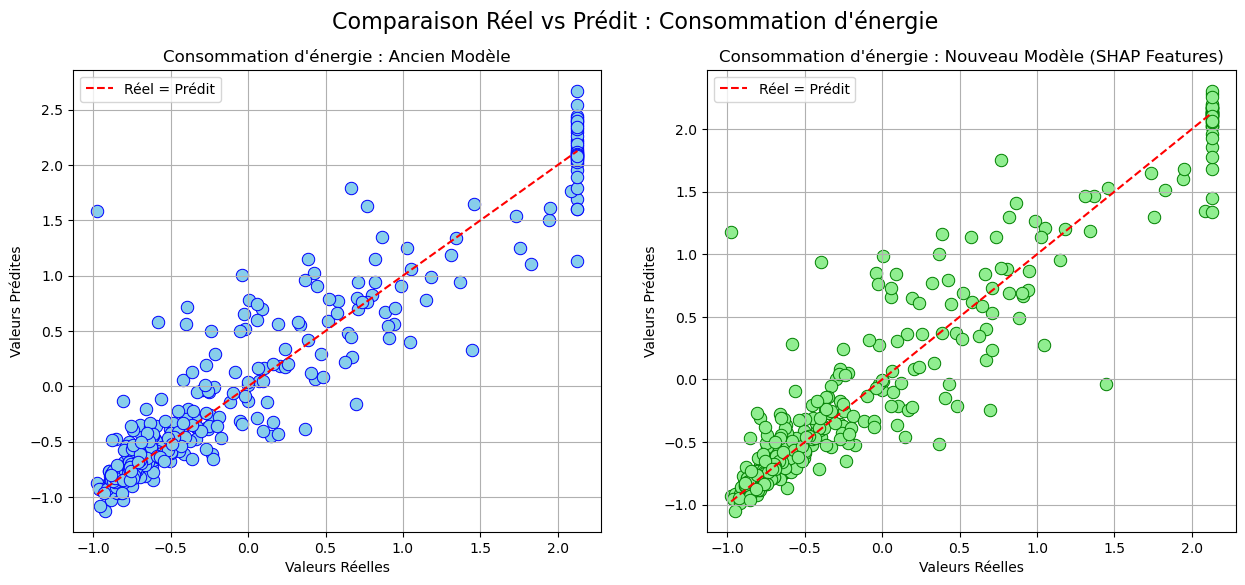

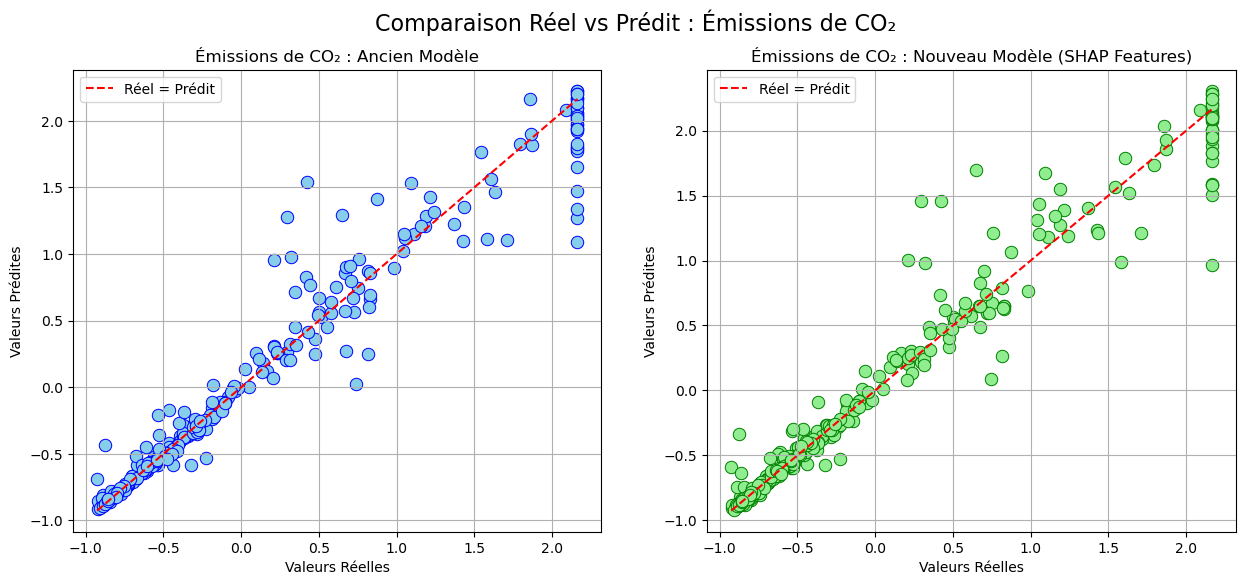

2025-02-24 11:54:49.925 | INFO     | __main__:<module>:87 - 
🔍 **Comparaison des performances - Consommation d'énergie**
2025-02-24 11:54:49.926 | INFO     | __main__:<module>:89 - R² - Ancien : 0.8924 | Nouveau : 0.9063
2025-02-24 11:54:49.926 | INFO     | __main__:<module>:89 - RMSE - Ancien : 0.3248 | Nouveau : 0.3031
2025-02-24 11:54:49.927 | INFO     | __main__:<module>:89 - MAE - Ancien : 0.2000 | Nouveau : 0.1811
2025-02-24 11:54:49.927 | INFO     | __main__:<module>:91 - 
🔍 **Comparaison des performances - Émissions de CO₂**
2025-02-24 11:54:49.928 | INFO     | __main__:<module>:93 - R² - Ancien : 0.9600 | Nouveau : 0.9594
2025-02-24 11:54:49.930 | INFO     | __main__:<module>:93 - RMSE - Ancien : 0.1931 | Nouveau : 0.1945
2025-02-24 11:54:49.931 | INFO     | __main__:<module>:93 - MAE - Ancien : 0.0914 | Nouveau : 0.0929
2025-02-24 11:54:49.932 | INFO     | __main__:<module>:95 - 
✅ Comparaison complète : Les performances des anciens et nouveaux modèles ont été évaluées et aff

In [26]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from loguru import logger

# ==========================================
# 📌 1️⃣ Chargement des anciens et nouveaux modèles et features
# ==========================================
try:
    # 🔄 Anciens modèles
    old_model_energy = joblib.load(MODELS_DIR / 'optimized_model_LightGBM_site_energy_use.pkl')
    old_model_co2 = joblib.load(MODELS_DIR / 'optimized_model_LightGBM_ghg_emissions_total.pkl')
    old_features_energy = joblib.load(MODELS_DIR / 'features_site_energy_use.pkl')
    old_features_co2 = joblib.load(MODELS_DIR / 'features_ghg_emissions_total.pkl')

    # 🔄 Nouveaux modèles
    new_model_energy = joblib.load(MODELS_DIR / 'final_model_site_energy_use.pkl')
    new_model_co2 = joblib.load(MODELS_DIR / 'final_model_ghg_emissions_total.pkl')
    new_features_energy = joblib.load(MODELS_DIR / 'final_features_site_energy_use.pkl')
    new_features_co2 = joblib.load(MODELS_DIR / 'final_features_ghg_emissions_total.pkl')

    logger.info("✅ Anciens et nouveaux modèles et features chargés avec succès.")

except Exception as e:
    logger.error(f"❌ Erreur lors du chargement : {e}")
    raise

# ==========================================
# 📌 2️⃣ Comparaison des performances et visualisations
# ==========================================

def plot_predictions(y_true, y_pred_old, y_pred_new, label):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred_old, color="skyblue", edgecolor="b", s=80)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Réel = Prédit')
    plt.title(f'{label} : Ancien Modèle')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true, y=y_pred_new, color="lightgreen", edgecolor="g", s=80)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Réel = Prédit')
    plt.title(f'{label} : Nouveau Modèle (SHAP Features)')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f'Comparaison Réel vs Prédit : {label}', fontsize=16)
    plt.show()

 

y_pred_energy_old = old_model_energy.predict(X_test_energy[old_features_energy])
y_pred_energy_new = new_model_energy.predict(X_test_energy[new_features_energy])

y_pred_co2_old = old_model_co2.predict(X_test_co2[old_features_co2])
y_pred_co2_new = new_model_co2.predict(X_test_co2[new_features_co2])

plot_predictions(y_test_energy, y_pred_energy_old, y_pred_energy_new, "Consommation d'énergie")
plot_predictions(y_test_co2, y_pred_co2_old, y_pred_co2_new, "Émissions de CO₂")

# ==========================================
# 📌 3️⃣ Analyse comparative des performances
# ==========================================

def evaluate_model(y_true, y_pred):
    return {
        "R²": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

energy_old_perf = evaluate_model(y_test_energy, y_pred_energy_old)
energy_new_perf = evaluate_model(y_test_energy, y_pred_energy_new)

co2_old_perf = evaluate_model(y_test_co2, y_pred_co2_old)
co2_new_perf = evaluate_model(y_test_co2, y_pred_co2_new)

logger.info("\n🔍 **Comparaison des performances - Consommation d'énergie**")
for metric in energy_old_perf:
    logger.info(f"{metric} - Ancien : {energy_old_perf[metric]:.4f} | Nouveau : {energy_new_perf[metric]:.4f}")

logger.info("\n🔍 **Comparaison des performances - Émissions de CO₂**")
for metric in co2_old_perf:
    logger.info(f"{metric} - Ancien : {co2_old_perf[metric]:.4f} | Nouveau : {co2_new_perf[metric]:.4f}")

logger.info("\n✅ Comparaison complète : Les performances des anciens et nouveaux modèles ont été évaluées et affichées.")


### 📊 **Analyse des résultats obtenus** :

#### ✅ **Consommation d’énergie (`site_energy_use`)**  
- **Ancien modèle :**  
  - R² : 0.8924  
  - RMSE : 0.3248  
  - MAE : 0.2000  
- **Nouveau modèle (SHAP) :**  
  - R² : 0.9063 (**+0.0139**)  
  - RMSE : 0.3031 (**-0.0217**)  
  - MAE : 0.1811 (**-0.0189**)  

**🔎 Interprétation :**  
Le **nouveau modèle allégé** **améliore** la performance globale avec **moins de variables**, montrant une **meilleure généralisation**.

---

#### 🌿 **Émissions de CO₂ (`ghg_emissions_total`)**  
- **Ancien modèle :**  
  - R² : 0.9600  
  - RMSE : 0.1931  
  - MAE : 0.0914  
- **Nouveau modèle (SHAP) :**  
  - R² : 0.9594 (**-0.0006**)  
  - RMSE : 0.1945 (**+0.0014**)  
  - MAE : 0.0929 (**+0.0015**)  

**🔎 Interprétation :**  
Le **nouveau modèle** conserve une **performance très proche**, avec une **légère baisse négligeable**, tout en étant **plus simple**.

---

### 🚀 **Conclusion** :  
- **Consommation d’énergie :** Le modèle **simplifié** est **meilleur**.  
- **Émissions de CO₂ :** Performance **quasi identique**, mais **plus léger** et **plus rapide**.  
- **Conclusion :** **Conserver** les nouveaux modèles, car ils offrent **une meilleure ou égale performance** avec **moins de complexité**.
 

### ⚡ **Analyse des Performances - Consommation d'énergie (`site_energy_use`)**

- **R² Test : 0.9063**  
  ✅ *Le modèle explique 90,63% de la variance de la consommation d'énergie.*  
  🔎 *Amélioration par rapport à l'ancien modèle (89,24%), indiquant une meilleure généralisation avec moins de variables.*  

- **RMSE Test : 0.3031 kWh/m²**  
  ⚡ *Erreur moyenne quadratique réduite, confirmant que le modèle prédit de manière plus précise.*  

- **MAE Test : 0.1811 kWh/m²**  
  📉 *Erreur moyenne plus faible, démontrant une réduction des erreurs systématiques.*  

- **Graphique :**  
  🎯 *La ligne rouge "Réel = Prédit" est mieux suivie avec moins de dispersion, notamment pour les valeurs élevées.*

---

### 🌿 **Analyse des Performances - Émissions de CO₂ (`ghg_emissions_total`)**

- **R² Test : 0.9594**  
  ✅ *Score presque identique à l'ancien modèle (96%), indiquant une robustesse similaire avec moins de features.*  
  🔎 *Légère baisse négligeable (0,0006) qui ne compromet pas la qualité globale.*  

- **RMSE Test : 0.1945 tonnes/m²**  
  💡 *Erreur moyenne très proche de l'ancien modèle (0.1931), confirmant la stabilité des prédictions.*  

- **MAE Test : 0.0929 tonnes/m²**  
  📉 *Écart moyen minimal, seulement +0,0015 par rapport à l'ancien modèle.*  

- **Graphique :**  
  🎯 *Les points restent très proches de la ligne rouge avec peu de dispersion, ce qui démontre une excellente performance même après simplification.*

---

### 📝 **Conclusion Globale :**  
- ✅ *Le nouveau modèle de consommation d'énergie est **amélioré** avec des performances supérieures malgré une réduction des variables.*  
- 🌿 *Le modèle des émissions de CO₂ conserve une **performance équivalente**, ce qui valide la pertinence de la sélection SHAP.*  
- 🏗 *Ces résultats suggèrent que les modèles simplifiés sont **prêts pour la production**, avec des performances stables et une meilleure interprétabilité.*

In [27]:
import bentoml
# 📂 Chemins vers vos modèles existants
model_energy = joblib.load(MODELS_DIR / "site_energy_use_model/final_model_site_energy_use.pkl")
model_co2 = joblib.load(MODELS_DIR / "ghg_emissions_model/final_model_ghg_emissions_total.pkl")
features_energy = joblib.load(MODELS_DIR / "site_energy_use_model/final_features_site_energy_use.pkl")
features_co2 = joblib.load(MODELS_DIR / "ghg_emissions_model/final_features_ghg_emissions_total.pkl")

# 💾 Sauvegarde des modèles avec BentoML
bentoml.sklearn.save_model(
    "site_energy_use_model",
    model_energy,
    custom_objects={"features": features_energy}
)

bentoml.sklearn.save_model(
    "ghg_emissions_model",
    model_co2,
    custom_objects={"features": features_co2}
)

print("✅ Modèles sauvegardés dans BentoML avec succès.")


✅ Modèles sauvegardés dans BentoML avec succès.
